In [ ]:
import os 

from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import numpy as np
model = SentenceTransformer("all-MiniLM-L6-v2")

def fastLexRank(df: pd.DataFrame) -> pd.DataFrame:
    posts = df["post"]
    #remove @mentions
    posts = posts.str.replace(r'@\w+', '', regex=True)
    #remove hashtags
    posts = posts.str.replace(r'#\w+', '', regex=True)
    #remove urls
    posts = posts.str.replace(r'http\S+', '', regex=True)
    embeddings = model.encode(posts, show_progress_bar=True)
    # sum in column
    z = embeddings.sum(axis=0)
    # normalize the sum
    z = z / np.sqrt((z**2).sum(axis=0))
    ap = np.dot(embeddings, z)
    # normalize the scores by its sum
    df["ap"] = ap
    df.sort_values(by="ap")
    return df

In [1]:
import json

with open(file="../../echo-chamber/data/mastodon.trump.json") as f:
    data = json.load(f)

In [2]:
import re
from bs4 import BeautifulSoup
from fast_langdetect import detect_language
md = []
for post in data:
    if not post["in_reply_to_id"]:
        reply = False
    else:
        reply = True
    content = post["content"]
    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(content, "html.parser")

    # Remove all 'a' tags entirely
    for a_tag in soup.find_all("a"):
        a_tag.unwrap()

    # Get the plain text
    plain_text = soup.get_text(separator=" ")

    # Regular expression to match and remove URLs
    cleaned_content = re.sub(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F])|\s)+",
        "",
        plain_text,
    )

    # Remove excess spaces left by removing the link
    cleaned_content = re.sub(r"\s+", " ", cleaned_content).strip()
    lang = detect_language(cleaned_content)
    if cleaned_content:
        md.append([post["id"], cleaned_content, lang, reply, post.get("in_reply_to_id", None),])

fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a s

In [3]:
import pandas as pd

md_df = pd.DataFrame(md, columns=["id", "post", "lang", "reply", "in_reply_to_id"])


In [4]:
import networkx as nx

md_graph = nx.DiGraph()
md_edge_list = md_df[["id", "in_reply_to_id"]].values.tolist()
# Create a directed graph

# Add edges, skipping any with None as parent
for child, parent in md_edge_list:
    if parent is not None:
        md_graph.add_edge(parent, child)
    else:
        # Optionally, add the root node manually
        md_graph.add_node(child)



In [59]:
md_df = fastLexRank(md_df)

Batches: 100%|██████████| 3457/3457 [00:38<00:00, 90.35it/s] 


In [73]:
md_df.sort_values(by='ap',ascending=False)[:20].to_csv("md_top20.csv")

In [76]:
data[0]

{'_id': '112543594850067662',
 'id': '112543594850067662',
 'created_at': '2024-06-01T21:56:11.000Z',
 'in_reply_to_id': None,
 'in_reply_to_account_id': None,
 'sensitive': False,
 'spoiler_text': '',
 'visibility': 'public',
 'language': 'en',
 'uri': 'https://mstdn.ca/users/Downshift/statuses/112543594650887090',
 'url': 'https://mstdn.ca/@Downshift/112543594650887090',
 'replies_count': 0,
 'reblogs_count': 0,
 'favourites_count': 0,
 'edited_at': None,
 'content': '<p>Model Emily <a href="https://mstdn.ca/tags/Ratajkowski" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>Ratajkowski</span></a>  became the latest celebrity to make a political fashion statement this week, sporting a black T-shirt with <a href="https://mstdn.ca/tags/Stormy" class="mention hashtag" rel="nofollow noopener noreferrer" target="_blank">#<span>Stormy</span></a> Daniels’ face on it the day Donald <a href="https://mstdn.ca/tags/Trump" class="mention hashtag" rel="nofollow noo

In [5]:
import json

with open(file="../../echo-chamber/data/bsky.trump.json") as f:
    bsky = json.load(f)


In [6]:
bsky_data = []
from fast_langdetect import detect_language

for post in bsky:
    if not post["record"].get("reply", None):
        reply = False
    else:
        reply = True
    if post["record"].get("text", None):
        language = post["record"].get("langs", None)
        language = language[0] if language else None
        if not language:
            language = detect_language(
                post["record"]["text"].replace("\n", " ")
            ).lower()
        bsky_data.append([post["_id"], post["record"]["text"], language, reply, post["record"].get("reply", {}).get("parent", {}).get('uri',None),])

In [7]:
import pandas as pd

bsky_df = pd.DataFrame(bsky_data, columns=["id", "post", "lang", "reply", "in_reply_to_id"])

In [8]:
bsky_graph = nx.DiGraph()
bsky_edge_list = bsky_df[["id", "in_reply_to_id"]].values.tolist()
# Create a directed graph

# Add edges, skipping any with None as parent
for child, parent in bsky_edge_list:
    if parent is not None:
        bsky_graph.add_edge(parent, child)
    else:
        # Optionally, add the root node manually
        bsky_graph.add_node(child)


In [92]:
bsky_graph.number_of_edges()

1681503

In [62]:
bsky_df = fastLexRank(bsky_df)

Batches: 100%|██████████| 73985/73985 [12:35<00:00, 97.90it/s] 


In [72]:
bsky_df.sort_values(by='ap',ascending=False)[:20].to_csv("bsky_top20.csv")

In [39]:
bsky_df.reply.value_counts()

reply
True     1681503
False     686010
Name: count, dtype: int64

In [6]:
bsky_df["lang"].value_counts()[:10]

In [9]:
bsky_df["lang"].value_counts()

lang
en     1299573
de      741698
ja      122146
fr       38315
sv       24420
        ...   
tt           1
kk           1
jbo          1
ur           1
sw           1
Name: count, Length: 122, dtype: int64

In [7]:
bsky_df["post"].nunique()

In [9]:
import json

with open(file="../../echo-chamber/data/truthsocial.trump.json") as f:
    ts = json.load(f)


In [10]:
import re
from bs4 import BeautifulSoup

ts_data = []
for post in ts:
    if post["in_reply_to_id"] or post["quote_id"]:
        reply = True
    else:
        reply = False
    content = post["content"]
    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(content, "html.parser")

    # Remove all 'a' tags entirely
    for a_tag in soup.find_all("a"):
        a_tag.unwrap()

    # Get the plain text
    plain_text = soup.get_text(separator=" ")

    # Regular expression to match and remove URLs
    cleaned_content = re.sub(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F])|\s)+",
        "",
        plain_text,
    )

    # Remove excess spaces left by removing the link
    cleaned_content = re.sub(r"\s+", " ", cleaned_content).strip()
    lang = detect_language(cleaned_content.replace("\n", " ").lower()).lower()
    if cleaned_content:
        ts_data.append([post["id"], cleaned_content, lang, reply, post.get("in_reply_to_id", None),])

fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.


fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a single sentence for accurate prediction.
fast-langdetect: Text contains newline characters or is too long. You should only pass a s

In [11]:
ts_df = pd.DataFrame(ts_data, columns=["id", "post", 'lang', 'reply', 'in_reply_to_id'])

In [12]:
ts_graph = nx.DiGraph()
ts_edge_list = ts_df[["id", "in_reply_to_id"]].values.tolist()
# Create a directed graph
# Add edges, skipping any with None as parent
for child, parent in ts_edge_list:
    if parent is not None:
        ts_graph.add_edge(parent, child)
    else:
        # Optionally, add the root node manually
        ts_graph.add_node(child)
ts_graph.number_of_edges()

3119722

In [40]:
ts_df.reply.value_counts()

reply
True     3126222
False      52129
Name: count, dtype: int64

In [41]:
ts_df.lang.value_counts()

lang
en     3023322
it       26964
de       18225
es       10194
ru        9397
        ...   
mwl          1
lrc          1
vec          1
mai          1
pam          1
Name: count, Length: 165, dtype: int64

In [68]:
ts_df = fastLexRank(ts_df)

Batches: 100%|██████████| 99324/99324 [08:41<00:00, 190.30it/s]


In [71]:
ts_df.sort_values(by='ap',ascending=False)[:20].to_csv("ts_lexrank.csv")

In [66]:
ts_df.sort_values(by='ap',ascending=False)

id  \
920506   112532586749922237   
2067990  112532337307420337   
2300568  112532451504847356   
1775862  112658407394215869   
1399536  112555356323676520   
...                     ...   
2830805  112600490006673479   
1443936  112543823177758976   
11528    112638354068443066   
478986   112615554498504917   
660162   112570040288016495   

                                                      post lang  reply  \
920506              Hahahah! Fuck you and fuck Trump!!!!!!   en   True   
2067990                  Get Fucked Trumpers! Hahahahahaha   en   True   
2300568  You’ve clearly lost it. 🤣🤣🤣🤣🤣🤣🤣🤣🤣🙂🙂🤣🤣🤣 yeeeeee...   en   True   
1775862  Oh, You’re one of those Trump shit crazy fucke...   en   True   
1399536  You're such a dumb fuck. It's "rig", you ignor...   en   True   
...                                                    ...  ...    ...   
2830805                 A stage of development in mammals.   en   True   
1443936        Present thosee instances in the transcript.   en   True   
11528    About the length of a bus queue on any given T...   en   True   
478986   Hospital protocol and withholding of early int...   en   True   
660162                                🤣🤣💦 I looked her up.   en   True   

               ap  
920506   0.654260  
2067990  0.637375  
2300568  0.632612  
1775862  0.625325  
1399536  0.623865  
...           ...  
2830805 -0.107641  
1443936 -0.109478  
11528   -0.116678  
478986  -0.123011  
660162  -0.154840  

[3178351 rows x 5 columns]

In [5]:
import pandas as pd
# Reload original full post columns directly from CSV files
ts_df = pd.read_csv("ts_lexrank.csv")
bsky_df = pd.read_csv("bsky_top20.csv")
md_df = pd.read_csv("md_top20.csv")

# Add platform labels
ts_df["Platform"] = "TruthSocial"
bsky_df["Platform"] = "Bluesky"
md_df["Platform"] = "Mastodon"

# Concatenate full original posts
full_posts_df = pd.concat([
    ts_df[["Platform", "post"]],
    bsky_df[["Platform", "post"]],
    md_df[["Platform", "post"]]
], axis=1,ignore_index=True)

# Rename for LaTeX export
#full_posts_df = full_posts_df.rename(columns={"post": "Post"})

# Generate full LaTeX table with no truncation
full_latex_content = full_posts_df.to_latex(
    index=False,
    escape=True,
    longtable=True,
    column_format=r">{\raggedright\arraybackslash}p{2.5cm} >{\raggedright\arraybackslash}p{13cm}"
)


In [14]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Step 1: Initialize the SBERT model
model = SentenceTransformer(
    "all-MiniLM-L6-v2",
)  # You can use other SBERT models as well

# Step 2: Define your two lists
list_bsky = list(bsky_df.loc[bsky_df['reply']==False, "post"])
list_ts = list(ts_df.loc[ts_df["reply"]==False, "post"])
list_md = list(md_df.loc[md_df["reply"]==False, "post"])
# Step 3: Compute embeddings for both lists
embeddings_bsky = model.encode(
    list_bsky, convert_to_tensor=True, show_progress_bar=True, batch_size=1024
)
embeddings_ts = model.encode(
    list_ts, convert_to_tensor=True, show_progress_bar=True, batch_size=1024
)

embeddings_md = model.encode(
    list_md, convert_to_tensor=True, show_progress_bar=True, batch_size=1024
)


Batches: 100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


In [16]:
# Step 4: Compute cosine similarity
sim_tb = util.pytorch_cos_sim(embeddings_ts.cpu(), embeddings_bsky.cpu())
sim_tm = util.pytorch_cos_sim(embeddings_ts.cpu(), embeddings_md.cpu())
sim_bm = util.pytorch_cos_sim(embeddings_bsky.cpu(), embeddings_md.cpu())


In [17]:

import networkx as nx
threshold = 0.7  # similarity threshold

# Offset functions to avoid index collisions
offset_bsky = len(embeddings_ts)
offset_masto = len(embeddings_ts) + len(embeddings_bsky)

# Helper to add weighted edges from sparse matrix
def add_edges_from_sim(sim_matrix, offset_a, offset_b):
    row, col = np.where(sim_matrix > threshold)
    weights = sim_matrix[row, col]
    edges = [
        (offset_a + i, offset_b + j, {"weight": float(w)})
        for i, j, w in zip(row, col, weights)
    ]
    return edges

# Build graph
G = nx.Graph()

# Add nodes with platform labels
G.add_nodes_from(range(len(embeddings_ts)), platform="truth")
G.add_nodes_from(
    range(offset_bsky, offset_bsky + len(embeddings_bsky)), platform="bluesky"
)
G.add_nodes_from(
    range(offset_masto, offset_masto + len(embeddings_md)), platform="mastodon"
)

# Add edges from all pairwise similarities
G.add_edges_from(add_edges_from_sim(sim_tb, 0, offset_bsky))
G.add_edges_from(add_edges_from_sim(sim_tm, 0, offset_masto))
G.add_edges_from(add_edges_from_sim(sim_bm, offset_bsky, offset_masto))

print(f"Tripartite graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Tripartite graph has 772143 nodes and 1137940 edges.


In [19]:
# Define your platform post lists
truth_posts = list_ts
bluesky_posts = list_bsky
mastodon_posts = list_md

# Compute offsets
offset_bsky = len(truth_posts)
offset_masto = len(truth_posts) + len(bluesky_posts)
components = list(nx.connected_components(G))
# find component larger than 1
components = [c for c in components if len(c) > 1]
component_posts = []

for component in components:
    posts = {
        "truth": [],
        "bluesky": [],
        "mastodon": [],
    }

    for node in component:
        if node < offset_bsky:
            posts["truth"].append(truth_posts[node])
        elif offset_bsky <= node < offset_masto:
            posts["bluesky"].append(bluesky_posts[node - offset_bsky])
        else:
            posts["mastodon"].append(mastodon_posts[node - offset_masto])

    component_posts.append(posts)


In [50]:
#writing to jsonl
import json
with open("tri_graph.jsonl", "w") as f:
    for component in component_posts:
        json.dump(component, f)
        f.write("\n")

In [24]:
import pandas as pd

component_posts_df = pd.DataFrame(component_posts)

In [38]:
component_posts_df = component_posts_df.map(lambda x: np.nan if len(x)==0 else x)
component_posts_df.dropna(how="any", inplace=True)

In [44]:
component_posts_df.to_json("triad_posts.jsonl", orient="records", lines=True)

In [13]:
import pandas as pd
component_posts_df = pd.read_json("triad_posts_annoted.jsonl", orient="records", lines=True)

    


In [14]:
import pandas as pd
import json
import re
df = component_posts_df.copy().dropna(how="any")
# Function to clean and parse the response JSON string
def parse_json_block(text):
    cleaned = re.sub(r"```json|```", "", text).strip()
    return json.loads(cleaned)

# Function to process the 'response' column (which contains the list of platform responses)
def extract_platform_fields(response_list):
    result = {}
    if not response_list:
        return np.nan
    for item in response_list:
        platform = item.get('platform')
        raw_response = item.get('response', '')
        try:
            parsed = parse_json_block(raw_response)
            for key, value in parsed.items():
                # Optional: normalize keys (e.g., replace spaces with underscores)
                safe_key = key.replace(" ", "_")
                result[f"{platform}_{safe_key}"] = value
        except Exception as e:
            print(f"Error parsing JSON for platform '{platform}': {e}")
            continue
    return pd.Series(result)

# Apply it to your DataFrame (replace `df` with your actual variable)
platform_fields = df['response'].apply(extract_platform_fields)

# Combine the extracted fields back into the DataFrame
df_final = pd.concat([df, platform_fields], axis=1)

# Done!
print(df_final.head())


Error parsing JSON for platform 'bluesky': Unterminated string starting at: line 6 column 18 (char 234)
Error parsing JSON for platform 'bluesky': Expecting value: line 1 column 1 (char 0)
Error parsing JSON for platform 'truth': Extra data: line 9 column 1 (char 168)
Error parsing JSON for platform 'bluesky': Extra data: line 9 column 1 (char 282)
Error parsing JSON for platform 'bluesky': Extra data: line 9 column 1 (char 218)
Error parsing JSON for platform 'mastodon': Extra data: line 9 column 1 (char 245)
                                                truth  \
1   [Trump knocks report, says he has 'never even ...   
2   [Trump says there is great unity in the GOP af...   
9   [Let's go Trump 💯💯💯, DO IT NOW TRUMP!!!!!!, BR...   
11  [Melania Trump to host $100,000-a-head fundrai...   
12  [America First Legal files FEC complaint again...   

                                              bluesky  \
1   [Trump: Mandatory Military Service Report 'Rid...   
2   [Trump claims 'great un

In [4]:
len(component_posts_df.iloc[1]["truth"])

6

In [ ]:
from transformers import pipeline
import torch
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
pipe = pipeline(
    "text-generation",
    model="google/gemma-3-12b-it",
    device="cuda",
    torch_dtype=torch.bfloat16
)

In [7]:

post_text = '.'.join(component_posts_df.iloc[1]["truth"])
prompt = f"""
You are a political discourse analyst.

Classify the following social media post based on:

1. Narrative Frame (e.g., corruption, persecution, legal justice, media bias, systemic inequality, etc.)
2. Main Subject (e.g., Trump, Biden, etc.)
3. Stance toward main subject (e.g., supportive, critical, neutral, unclear)
4. Topic Focus (e.g., legal, cultural, institutional, personal attack)

Return in JSON format.

Post:
\"\"\"{post_text}\"\"\"
"""

messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant."
    },
    {
        "role": "user",
        "content":  prompt
    },
]

output = pipe(messages, max_new_tokens=200)
print(output[0]["generated_text"][-1]["content"])
# Okay, let's take a look! 
# Based on the image, the animal on the candy is a **turtle**. 
# You can see the shell shape and the head and legs.


```json
{
  "Narrative Frame": "Media Bias",
  "Main Subject": "Trump",
  "Stance toward main subject": "Supportive",
  "Topic Focus": "Institutional (specifically, criticism of media)"
}
```


```json
{
  "Narrative Frame": "Personal Attack & Political Strategy",
  "Main Subject": "Donald Trump",
  "Stance toward main subject": "Critical",
  "Topic Focus": "Political/Institutional (specifically, policy proposal and perceived motivations) & Personal Attack"
}
```


In [24]:
#loop throught the components
from tqdm.auto import tqdm
#response = []
for i, component in tqdm(enumerate(component_posts_df.to_dict(orient="records"))):
    print(f"Component {i+1}")
    if i != 221:
        continue
    current_response = []
    for platform, posts in component.items():
        if len(posts) > 10:
            continue

        post = ".".join(posts)
        prompt = f"""
            You are a political discourse analyst.

            Classify the following social media post based on:

            1. Narrative Frame (e.g., corruption, persecution, legal justice, media bias, systemic inequality, etc.)
            2. Main Subject (e.g., Trump, Biden, etc.)
            3. Stance toward main subject (e.g., supportive, critical, neutral, unclear)
            4. Topic Focus (e.g., legal, cultural, institutional, personal attack)

            Return in JSON format.

            Post:
            \"\"\"{post}\"\"\"
            """

        messages = [
                {
                    "role": "system",
                    "content": "You are a helpful assistant."
                },
                {
                    "role": "user",
                    "content":  prompt
                },
            ]

        output = pipe(messages, max_new_tokens=200)
        current_response.append({"platform": platform, "response": output[0]["generated_text"][-1]["content"]})
    response.insert(i, current_response)
    
        

0it [00:00, ?it/s]

Component 1
Component 2
Component 3
Component 4
Component 5
Component 6
Component 7
Component 8
Component 9
Component 10
Component 11
Component 12
Component 13
Component 14
Component 15
Component 16
Component 17
Component 18
Component 19
Component 20
Component 21
Component 22
Component 23
Component 24
Component 25
Component 26
Component 27
Component 28
Component 29
Component 30
Component 31
Component 32
Component 33
Component 34
Component 35
Component 36
Component 37
Component 38
Component 39
Component 40
Component 41
Component 42
Component 43
Component 44
Component 45
Component 46
Component 47
Component 48
Component 49
Component 50
Component 51
Component 52
Component 53
Component 54
Component 55
Component 56
Component 57
Component 58
Component 59
Component 60
Component 61
Component 62
Component 63
Component 64
Component 65
Component 66
Component 67
Component 68
Component 69
Component 70
Component 71
Component 72
Component 73
Component 74
Component 75
Component 76
Component 77
Componen

365it [00:08, 44.01it/s]

Component 223
Component 224
Component 225
Component 226
Component 227
Component 228
Component 229
Component 230
Component 231
Component 232
Component 233
Component 234
Component 235
Component 236
Component 237
Component 238
Component 239
Component 240
Component 241
Component 242
Component 243
Component 244
Component 245
Component 246
Component 247
Component 248
Component 249
Component 250
Component 251
Component 252
Component 253
Component 254
Component 255
Component 256
Component 257
Component 258
Component 259
Component 260
Component 261
Component 262
Component 263
Component 264
Component 265
Component 266
Component 267
Component 268
Component 269
Component 270
Component 271
Component 272
Component 273
Component 274
Component 275
Component 276
Component 277
Component 278
Component 279
Component 280
Component 281
Component 282
Component 283
Component 284
Component 285
Component 286
Component 287
Component 288
Component 289
Component 290
Component 291
Component 292
Component 293
Compon

In [201]:
df_final.columns

Index(['truth', 'bluesky', 'mastodon', 'response', 'truth_response',
       'bluesky_response', 'mastodon_response', 'truth_Narrative_Frame',
       'truth_Main_Subject', 'truth_Stance_toward_main_subject',
       'truth_Topic_Focus', 'bluesky_Narrative_Frame', 'bluesky_Main_Subject',
       'bluesky_Stance_toward_main_subject', 'bluesky_Topic_Focus',
       'mastodon_Narrative_Frame', 'mastodon_Main_Subject',
       'mastodon_Stance_toward_main_subject', 'mastodon_Topic_Focus',
       'mastodon_Stance_toward_Main_Subject', 'truth_Explanation',
       'bluesky_Stance_toward_Main_Subject'],
      dtype='object')

/tmp/ipykernel_726452/2682651831.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df_final[['truth_Stance_toward_main_subject', 'bluesky_Stance_toward_main_subject', "mastodon_Stance_toward_main_subject"]].applymap(clean_stance)
/tmp/ipykernel_726452/2682651831.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  color_matrix = df_transposed.applymap(lambda x: color_map.get(x, '#dddddd'))


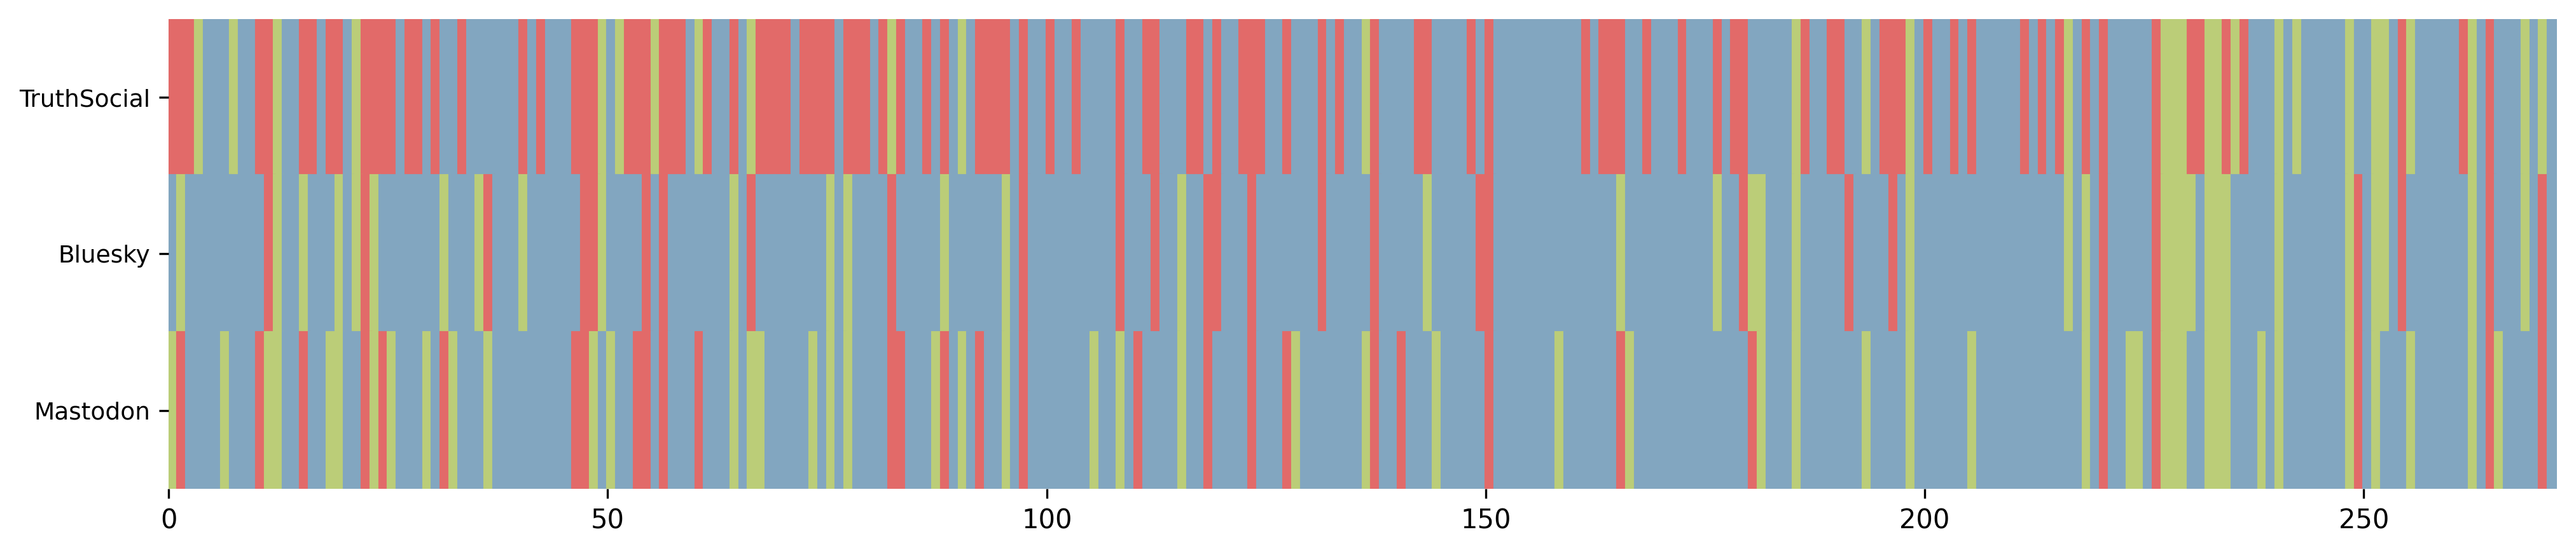

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def clean_stance(value):
    value = str(value).lower()
    if 'critical' in value:
        return 'critical'
    elif 'supportive' in value:
        return 'supportive'
    elif 'neutral' in value:
        return 'neutral'
    else:
        return 'neutral'  # optional fallback

# Apply to your DataFrame (excluding the record_id)
df_cleaned = df_final[['truth_Stance_toward_main_subject', 'bluesky_Stance_toward_main_subject', "mastodon_Stance_toward_main_subject"]].applymap(clean_stance)


# Create a color map
color_map = {
    'critical': '#82a6c0',
    'neutral': '#bbcd78',
    'supportive': '#e26a69',
    'unknown': '#dddddd'  # fallback color
}

# Create color matrix
# Transpose so platforms are rows, records are columns
df_transposed = df_cleaned.T

# Color map
color_map = {
    'critical': '#82a6c0',
    'neutral': '#bbcd78',
    'supportive': '#e26a69',
    'unknown': '#dddddd'
}
color_matrix = df_transposed.applymap(lambda x: color_map.get(x, '#dddddd'))
# Plot
fig, ax = plt.subplots(figsize=(len(df_transposed.columns) * 0.05, 3), dpi=300)  # 🔄 Wide, short
for i in range(len(df_transposed)):
    for j in range(len(df_transposed.columns)):
        ax.add_patch(plt.Rectangle((j, i), 1, 5, color=color_matrix.iat[i, j]))

# Style
y_ticks_label = ['TruthSocial', 'Bluesky', 'Mastodon']

ax.set_xlim(0, len(df_transposed.columns))
ax.set_ylim(0, len(df_transposed))
#ax.set_xticks([])
ax.set_yticks([i + 0.5 for i in range(len(df_transposed.index))])
ax.set_yticklabels(y_ticks_label, fontsize=9)
ax.invert_yaxis()
#ax.set_aspect('equal')
plt.box(False)
#plt.title('Stance Heatmap', fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
component_posts_df = df_final

In [16]:
from tqdm import tqdm
truth_posts = []
bluesky_posts = []
mastodon_posts = []
truth_posts_to_matched_ids = {}
bluesky_posts_to_matched_ids = {}
mastodon_posts_to_matched_ids = {}
for i, component in tqdm(enumerate(component_posts_df.to_dict(orient="records"))):
    truth_posts.extend(component["truth"])
    truth_posts_to_matched_id = { post:i for post in component["truth"]}
    truth_posts_to_matched_ids.update(truth_posts_to_matched_id)
    bluesky_posts.extend(component["bluesky"])
    bluesky_posts_to_matched_id = {post:i for post in component["bluesky"]}
    bluesky_posts_to_matched_ids.update(bluesky_posts_to_matched_id)
    mastodon_posts.extend(component["mastodon"])
    mastodon_posts_to_matched_id = {post:i for post in component["mastodon"]}
    mastodon_posts_to_matched_ids.update(mastodon_posts_to_matched_id)
    

272it [00:00, 331065.20it/s]


In [17]:
truth_posts_post_to_id = ts_df.set_index("post")["id"].to_dict()
bluesky_posts_post_to_id = bsky_df.set_index("post")["id"].to_dict()
mastodon_posts_post_to_id = md_df.set_index("post")["id"].to_dict()

In [18]:
truth_posts_id = []
for post in truth_posts:
    truth_posts_id.append(truth_posts_post_to_id[post])
bluesky_posts_id = []
for post in bluesky_posts:
    bluesky_posts_id.append(bluesky_posts_post_to_id[post])
mastodon_posts_id = []
for post in mastodon_posts:
    mastodon_posts_id.append(mastodon_posts_post_to_id[post])


In [19]:
len(truth_posts_id)

588

In [20]:
#fetch trees of truth posts id

#all the descendants of the post
ts_trees = {}
for root in truth_posts_id:
    descendants = nx.descendants(ts_graph, root)
    tree_nodes = {root} | descendants
    ts_trees[root] = ts_graph.subgraph(tree_nodes).copy()

#fetch trees of bsky posts id
bsky_trees = {}
for root in bluesky_posts_id:
    descendants = nx.descendants(bsky_graph, root)
    tree_nodes = {root} | descendants
    bsky_trees[root] = bsky_graph.subgraph(tree_nodes).copy()
#fetch trees of mastodon posts id
mastodon_trees = {}
for root in mastodon_posts_id:
    descendants = nx.descendants(md_graph, root)
    tree_nodes = {root} | descendants
    mastodon_trees[root] = md_graph.subgraph(tree_nodes).copy()


In [21]:
# tree statistis: depth, breadth, number of nodes

def tree_statistics(tree):
    # Calculate depth (longest path from root to leaf)
    depth = nx.dag_longest_path_length(tree)
    
    # Get the root (assuming it's the first node with in-degree 0)
    roots = [n for n in tree.nodes() if tree.in_degree(n) == 0]
    if not roots:
        raise ValueError("Tree has no root (in-degree 0 node).")
    root = roots[0]
    
    # Compute levels from root
    levels = nx.single_source_shortest_path_length(tree, root)
    
    # Count how many nodes at each level
    level_counts = {}
    for level in levels.values():
        level_counts[level] = level_counts.get(level, 0) + 1
    
    # Breadth is the max number of nodes at the same level
    breadth = max(level_counts.values())
    
    # Total number of nodes
    num_nodes = tree.number_of_nodes()
    
    return depth, breadth, num_nodes

ts_stats = {}
for root, tree in ts_trees.items():
    if tree.number_of_nodes() == 0:
        ts_stats[root] = {
            "depth": 0,
            "breadth": 0,
            "num_nodes": 1
        }
        continue
    depth, breadth, num_nodes = tree_statistics(tree)
    ts_stats[root] = {
        "depth": depth,
        "breadth": breadth,
        "num_nodes": num_nodes
    }
bsky_stats = {}
for root, tree in bsky_trees.items():
    if tree.number_of_nodes() == 0:
        bsky_stats[root] = {
            "depth": 0,
            "breadth": 0,
            "num_nodes": 1
        }
        continue
    depth, breadth, num_nodes = tree_statistics(tree)
    bsky_stats[root] = {
        "depth": depth,
        "breadth": breadth,
        "num_nodes": num_nodes
    }
mastodon_stats = {}
for root, tree in mastodon_trees.items():
    if tree.number_of_nodes() == 0:
        mastodon_stats[root] = {
            "depth": 0,
            "breadth": 0,
            "num_nodes": 1
        }
        continue
    depth, breadth, num_nodes = tree_statistics(tree)
    mastodon_stats[root] = {
        "depth": depth,
        "breadth": breadth,
        "num_nodes": num_nodes
    }

In [22]:
ts_stats_df = pd.DataFrame.from_dict(ts_stats, orient="index")
ts_stats_df["platform"] = "truth"
ts_stats_df["post_id"] = ts_stats_df.index
ts_stats_df.reset_index(drop=True, inplace=True)
ts_stats_df.rename(columns={"index": "post_id"}, inplace=True)
bsky_stats_df = pd.DataFrame.from_dict(bsky_stats, orient="index")
bsky_stats_df["platform"] = "bluesky"
bsky_stats_df["post_id"] = bsky_stats_df.index
bsky_stats_df.reset_index(drop=True, inplace=True)
bsky_stats_df.rename(columns={"index": "post_id"}, inplace=True)
mastodon_stats_df = pd.DataFrame.from_dict(mastodon_stats, orient="index")
mastodon_stats_df["platform"] = "mastodon"
mastodon_stats_df["post_id"] = mastodon_stats_df.index
mastodon_stats_df.reset_index(drop=True, inplace=True)
mastodon_stats_df.rename(columns={"index": "post_id"}, inplace=True)
# Concatenate all stats

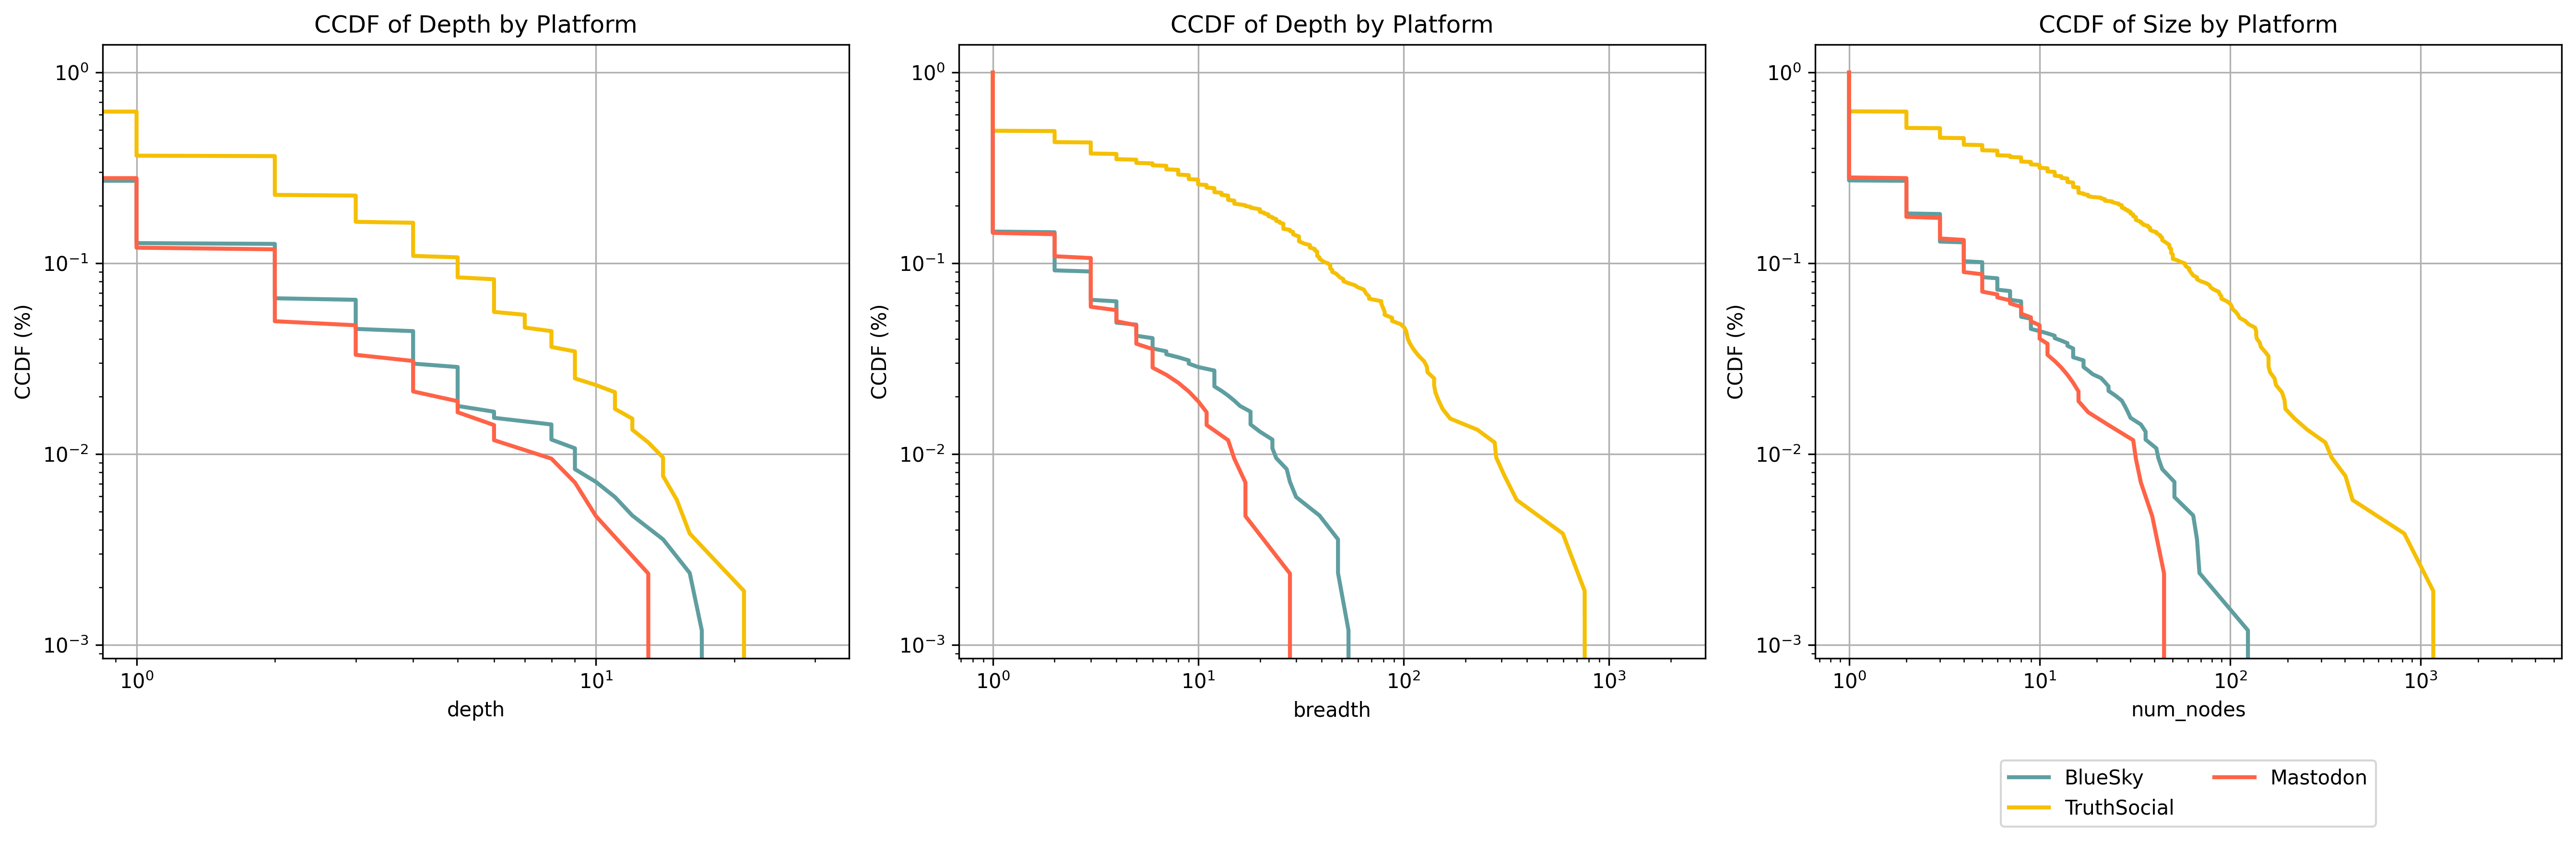

In [23]:
#plot the ccdf of the trees
import matplotlib.pyplot as plt
import numpy as np
metrics = ["depth", "breadth", "num_nodes"]
# Concatenate all stats
df = pd.concat([ts_stats_df, bsky_stats_df, mastodon_stats_df], ignore_index=True)
# Define Azure and Gold colors
colors = {"bluesky": "#5F9EA0", "truth": "#F5BF03", "mastodon": "#FF6347"}  

# Plot CCDF comparison by platform
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)  # 1 row, 4 columns

for idx, metric in enumerate(metrics):
    for platform in ["bluesky", "truth", 'mastodon']:
        values = df[df["platform"] == platform][metric].dropna()
        sorted_vals = np.sort(values)
        ccdf = 1 - np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
        axes[idx].plot(sorted_vals, ccdf, label=f"{platform.capitalize()}",
                       linewidth=2, color=colors[platform])
    if metric == "depth":
        metric_str = "Depth"
    elif metric == "num_nodes":
        metric_str = "Size"
    elif metric_str == "breadth":
        metric = "Breadth"
    elif metric == "structural_virality":
        metric_str = "Structural Virality"

    if metric != "structural_virality":
        axes[idx].set_xscale("log")  # Apply log scale to x-axis
    axes[idx].set_yscale("log")  # Keep y-axis in log scale
    axes[idx].set_xlabel(metric)
    axes[idx].set_ylabel("CCDF (%)")
    axes[idx].set_title(f"CCDF of {metric_str} by Platform")
    axes[idx].grid()



plt.legend(
    labels=["BlueSky", "TruthSocial", "Mastodon"],
    loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2
)  # Move legend outside
plt.tight_layout()
plt.show()

In [24]:
ts_stats_df['post'] = ts_stats_df['post_id'].map(ts_df.set_index('id')['post'])
bsky_stats_df['post'] = bsky_stats_df['post_id'].map(bsky_df.set_index('id')['post'])
mastodon_stats_df['post'] = mastodon_stats_df['post_id'].map(md_df.set_index('id')['post'])

In [25]:
ts_stats_df['matched_id'] = ts_stats_df['post'].map(truth_posts_to_matched_ids)
bsky_stats_df['matched_id'] = bsky_stats_df['post'].map(bluesky_posts_to_matched_ids)
mastodon_stats_df['matched_id'] = mastodon_stats_df['post'].map(mastodon_posts_to_matched_ids)


In [71]:
ts_stats_df.loc[ts_stats_df['matched_id']==0,]

depth  breadth  num_nodes platform             post_id  \
0      2        9         11    truth  112599632446881868   
1      4       60         79    truth  112600139551829710   
2     15     2018       3643    truth  112598565438227864   
3      6       17         34    truth  112609261571359342   
4      2        8         10    truth  112598950971967646   
5      4       26         34    truth  112603911819158450   

                                                post  matched_id  
0  Trump knocks report, says he has 'never even t...           0  
1  'Just another fake story': Trump responds to '...           0  
2  The Fake News Washington Post came up with the...           0  
3  "The Fake News Washington Post came up with th...           0  
4  Trump shoots down suggestions he would institu...           0  
5  Trump refutes outlandish 'Fake News' about man...           0

In [27]:
bsky_stats_df.loc[bsky_stats_df['matched_id'] == 0, ]

depth  breadth  num_nodes platform  \
0      0        1          1  bluesky   
1      0        1          1  bluesky   
2      0        1          1  bluesky   
3      0        1          1  bluesky   
4      0        1          1  bluesky   

                                             post_id  \
0  at://did:plc:flijdq6nzuscczuhvv2lt7bp/app.bsky...   
1  at://did:plc:oety7qbfx7x6exn2ytrwikmr/app.bsky...   
2  at://did:plc:qju2aubekbxir5c4xrgkcf2x/app.bsky...   
3  at://did:plc:ffszxx7ochbqzn2k6vvz4gxu/app.bsky...   
4  at://did:plc:4hm6gb7dzobynqrpypif3dck/app.bsky...   

                                                post  matched_id  
0  Trump: Mandatory Military Service Report 'Ridi...           0  
1  Trump Lashes Out Over Report He’d Enforce Mand...           0  
2  I don't know why Donald Trump is so gung-ho ab...           0  
3  The chief reason trump. Vance, et al are think...           0  
4  @Forbes: Trump Hits Back At Claims He’d Consid...           0

In [28]:
mastodon_stats_df.loc[mastodon_stats_df['matched_id'] == 0, ]

depth  breadth  num_nodes  platform             post_id  \
0      0        1          1  mastodon  112597799705588821   

                                                post  matched_id  
0  “Influential figures in Donald Trump’s orbit, ...           0

In [29]:
bsky_stats_df.loc[bsky_stats_df['matched_id'] == 170, ] 

depth  breadth  num_nodes platform  \
526     14       48        235  bluesky   
527      0        1          1  bluesky   
528      0        1          1  bluesky   

                                               post_id  \
526  at://did:plc:qrllvid7s54k4hnwtqxwetrf/app.bsky...   
527  at://did:plc:ocpuxu5mc5ix3zxfsj2yc3qk/app.bsky...   
528  at://did:plc:wfjbf2z22wuusrvdrl7t372c/app.bsky...   

                                                  post  matched_id  
526  DOJ unseals indictment against doctor accused ...         170  
527  Biden regime unseals indictment of Dr. Eithan ...         170  
528  \nSurgeon Indicted By Biden DOJ For Blowing Wh...         170

In [30]:
ts_stats_df.loc[ts_stats_df['matched_id'] == 170, ]

depth  breadth  num_nodes platform             post_id  \
395      1       37         38    truth  112637571132616714   
396      6      143        187    truth  112575531497957928   
397      3       88        107    truth  112634620253719127   
398      3       30         49    truth  112577694963161157   
399      1        3          4    truth  112575541330131129   

                                                  post  matched_id  
395  DOJ unsealing indictment against whistleblower...         170  
396  DEVELOPING : The Biden DOJ has indicted Dr. Ei...         170  
397  Biden Regime Unseals Indictment Against Texas ...         170  
398  BREAKING: Dr. Eithan Haim, the whistleblower w...         170  
399  The Biden DOJ has indicted Dr. Eithan Haim, a ...         170

In [31]:
mastodon_stats_df.loc[mastodon_stats_df['matched_id'] == 170, ]

depth  breadth  num_nodes  platform             post_id  \
275      3        6         10  mastodon  112633886021231318   

                                                  post  matched_id  
275  The doctor who leaked HIPAA-protected info abo...         170

In [32]:
ts_anchor_ids = ts_stats_df.loc[ts_stats_df['matched_id'] == 0,'post_id'].values
ts_anchor_bsky_ids = bsky_stats_df.loc[bsky_stats_df['matched_id'] == 0,'post_id'].values
ts_anchor_mastodon_ids = mastodon_stats_df.loc[mastodon_stats_df['matched_id'] == 0,'post_id'].values
bsky_anchor_ids = bsky_stats_df.loc[bsky_stats_df['matched_id'] == 170,'post_id'].values
bsky_anchor_ts_ids = ts_stats_df.loc[ts_stats_df['matched_id'] == 170,'post_id'].values
bsky_anchor_mastodon_ids = mastodon_stats_df.loc[mastodon_stats_df['matched_id'] == 170,'post_id'].values

In [33]:
ts_anchor_posts_and_replies = []
for post_id in ts_anchor_ids:
    descendants = nx.descendants(ts_graph, post_id)
    tree_nodes = {post_id} | descendants
    truth_id_to_post = { post_id: post for post, post_id in truth_posts_post_to_id.items()}
    posts = [truth_id_to_post.get(post_id) for post_id in tree_nodes]
    ts_anchor_posts_and_replies.extend(posts)

In [35]:
from vllm import LLM, SamplingParams
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"
sampling_params = SamplingParams(temperature=0.8, top_p=0.95)
llm = LLM(model="google/gemma-3-12b-it",tensor_parallel_size=2)


INFO 03-29 21:43:52 [config.py:585] This model supports multiple tasks: {'embed', 'generate', 'classify', 'score', 'reward'}. Defaulting to 'generate'.
INFO 03-29 21:43:55 [config.py:1519] Defaulting to use mp for distributed inference
INFO 03-29 21:43:55 [config.py:1697] Chunked prefill is enabled with max_num_batched_tokens=16384.
INFO 03-29 21:43:58 [core.py:54] Initializing a V1 LLM engine (v0.8.2) with config: model='google/gemma-3-12b-it', speculative_config=None, tokenizer='google/gemma-3-12b-it', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=131072, download_dir=None, load_format=auto, tensor_parallel_size=2, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar', reasoning_backend=None), observabilit

(VllmWorker rank=0 pid=746911) Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
(VllmWorker rank=1 pid=746940) Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


(VllmWorker rank=1 pid=746940) INFO 03-29 21:45:26 [gpu_model_runner.py:1174] Starting to load model google/gemma-3-12b-it...
(VllmWorker rank=1 pid=746940) (VllmWorker rank=0 pid=746911) INFO 03-29 21:45:26 [config.py:3243] cudagraph sizes specified by model runner [1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504, 512] is overridden by config [512, 384, 256, 128, 4, 2, 1, 392, 264, 136, 8, 400, 272, 144, 16, 408, 280, 152, 24, 416, 288, 160, 32, 424, 296, 168, 40, 432, 304, 176, 48, 440, 312, 184, 56, 448, 320, 192, 64, 456, 328, 200, 72, 464, 336, 208, 80, 472, 344, 216, 88, 120, 480, 352, 248, 224, 96, 488, 504, 360, 232, 104, 496, 368, 240, 112, 376]
INFO 03-29 21:45:26 [gpu_model_runner.py:1174] Starting to load model googl

Loading safetensors checkpoint shards:   0% Completed | 0/5 [00:00<?, ?it/s]


(VllmWorker rank=0 pid=746911) INFO 03-29 21:45:29 [loader.py:447] Loading weights took 2.51 seconds
(VllmWorker rank=1 pid=746940) INFO 03-29 21:45:29 [loader.py:447] Loading weights took 2.52 seconds
(VllmWorker rank=1 pid=746940) INFO 03-29 21:45:58 [gpu_model_runner.py:1186] Model loading took 11.9641 GB and 3.086555 seconds
(VllmWorker rank=0 pid=746911) INFO 03-29 21:45:58 [gpu_model_runner.py:1186] Model loading took 11.9641 GB and 2.917799 seconds
(VllmWorker rank=0 pid=746911) (VllmWorker rank=1 pid=746940) INFO 03-29 21:45:58 [gpu_model_runner.py:1456] Encoder cache will be initialized with a budget of 16384 tokens, and profiled with 64 image items of the maximum feature size.
INFO 03-29 21:45:58 [gpu_model_runner.py:1456] Encoder cache will be initialized with a budget of 16384 tokens, and profiled with 64 image items of the maximum feature size.
(VllmWorker rank=0 pid=746911) INFO 03-29 21:46:15 [backends.py:415] Using cache directory: /home/maolee/.cache/vllm/torch_compile

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [36]:
def analyze_reply_chain(root_post, replies):
    prompt = f"""
    You are analyzing an online conversation.

    Root Post:
    \"\"\"{root_post}\"\"\"

    Replies:
    {replies}

    Instructions:
    Identify whether replies reinforce, challenge, or shift the narrative of the root post.

    - Reinforce: The reply supports Trump and echoes the claim that The Washington Post is "Fake News."

    - Challenge: The reply supports the reporting by The Washington Post and disagrees with labeling it as "Fake News."

    - Shift: The reply introduces a new perspective or topic that is not directly related to Trump or The Washington Post, such as media in general, unrelated political issues, or broader societal commentary.

    ONLY output one category from: ["reinforce", "challenge", "shift"].
    """
    

    return prompt
root_post = "The Fake News Washington Post came up with the ridiculous idea that Donald J. Trump will call for Mandatory Military Service. This is only a continuation of their EIGHT YEAR failed attempt to damage me with the Voters. The Story is completely untrue. In fact, I never even thought of that idea. Only a degenerate former Newspaper, which has lost 50% of its Readers, would fabricate such a tale. Just another Fake Story, one of many, made up by the DEAD Washington Compost!"


In [37]:
batch_size = 8
responses_all = []
from tqdm.auto import tqdm
for i in tqdm(range(0, len(ts_anchor_posts_and_replies), batch_size)):
    batch = ts_anchor_posts_and_replies[i:i+batch_size]
    batch = [post for post in batch if post]
    batch = [analyze_reply_chain(root_post, post) for post in batch]
    responses = llm.generate(batch, sampling_params)
    responses = [response.outputs[0].text for response in responses]
    responses_all.extend(responses)
    if i<=16:
        print(responses_all)
    


  0%|          | 0/477 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 8/8 [00:00<00:00, 12.86it/s, est. speed input: 3532.65 toks/s, output: 51.45 toks/s]


['reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n']


Processed prompts: 100%|██████████| 7/7 [00:00<00:00, 76.17it/s, est. speed input: 20825.28 toks/s, output: 305.39 toks/s]


['reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n']


Processed prompts: 100%|██████████| 7/7 [00:00<00:00, 76.27it/s, est. speed input: 21013.98 toks/s, output: 306.71 toks/s]


['reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n', 'reinforce\n']


Processed prompts: 100%|██████████| 2/2 [00:00<00:00, 23.50it/s, est. speed input: 7375.00 toks/s, output: 117.76 toks/s]


In [38]:
def parse_output(input):
    if "reinforce" in input:
        return "reinforce"
    elif "challenge" in input:
        return "challenge"
    elif "shift" in input:
        return "shift"
    else:
        return "unknown"
    
#parse the output
parsed_responses = [parse_output(response) for response in responses_all]

In [39]:
ts_anchor_posts_and_replies = [post for post in ts_anchor_posts_and_replies if post]

In [40]:
ts_anchor_analysis = pd.DataFrame({
    "post": ts_anchor_posts_and_replies,
    "response": parsed_responses
})

In [73]:
ts_anchor_analysis

post   response
0     MSM constantly lies about President Trump cons...  reinforce
1     It couldn’t hurt, at this point. Need to get t...  reinforce
2     The Draft would only be necessary under extrem...  reinforce
3     Because we weren't going to War every time we ...  reinforce
4     Didn't Biden recently say something about rein...  reinforce
...                                                 ...        ...
3492                               Fuck the fake news .  reinforce
3493  My husband retired MC. Our youngest son spent ...  reinforce
3494  I 100% agree with you there. I don't recommend...  reinforce
3495  THE LYING FAKE NEWS MEDIA IS STARTING THEIR LY...  reinforce
3496  Media lies won’t work this time. November 5th ...  reinforce

[3497 rows x 2 columns]

In [41]:
ts_anchor_analysis.loc[ts_anchor_analysis["response"] == "challenge", "post"].values

array(['Thank you for 22 years. That’s a long time to be in the Army. 🤣🤣 Come on, man. You have an uncle or cousin or aunt or grandfather or someone in your family who served. Many, possibly most, multi-generation American families do. Not the trumps. And even that would be ok, if they respected those who have served and didn’t mock the service of POWs like John McCain and disparage our war dead.',
       'It’s time to start listening to the candidates for president. Trump’s rallies are a joke. There is not one intelligent thread of information related to the running of United States of America. It’s all about him and what’s happened to him. He couldn’t solve the pandemic and he certainly wouldn’t be able to resolve a recession, he surrounds himself with idiots who then fires when they don’t agree with him. Biden is surrounded by smart people and he takes the advice of smart people. Biden has created more jobs than any other president and lowered the cost of prescription drugs for Amer

In [42]:
from collections import Counter
# Count occurrences of each category
counts = Counter(parsed_responses)

In [43]:
counts

Counter({'reinforce': 3411, 'shift': 58, 'challenge': 28})

In [273]:
negative_conts = [annot[0]['label'] for annot in ts_anchor_posts_and_replies_sentiment if annot[0]['label'] == 'NEGATIVE']
positive_conts = [annot[0]['label'] for annot in ts_anchor_posts_and_replies_sentiment if annot[0]['label'] == 'POSITIVE']


In [274]:
len(negative_conts), len(positive_conts)

(2578, 919)

In [44]:
ts_anchor_bsky_posts_and_replies = []
for post_id in ts_anchor_bsky_ids:
    descendants = nx.descendants(bsky_graph, post_id)
    tree_nodes = {post_id} | descendants
    bsky_id_to_post = { post_id: post for post, post_id in bluesky_posts_post_to_id.items()}
    posts = [bsky_id_to_post.get(post_id) for post_id in tree_nodes]
    ts_anchor_bsky_posts_and_replies.extend(posts)

    

In [45]:
bsky_anchor_posts_and_replies = []

for post_id in bsky_anchor_ids:
    descendants = nx.descendants(bsky_graph, post_id)
    tree_nodes = {post_id} | descendants
    bsky_id_to_post = { post_id: post for post, post_id in bluesky_posts_post_to_id.items()}
    posts = [bsky_id_to_post.get(post_id) for post_id in tree_nodes]
    bsky_anchor_posts_and_replies.extend(posts)
    

In [61]:
#llm 
batch_size = 8
responses_all_bsky = []
def analyze_reply_chain(root_post, replies):
    prompt = f"""
    You are analyzing an online conversation.

    Root Post:
    \"\"\"{root_post}\"\"\"

    Replies:
    {replies}

    Instructions:
    - Identify whether replies favor, against, or irrelevant the narrative of the root post.
    Favor: The reply criticizes the doctor’s alleged behavior (e.g., leaking private health records), supports the Department of Justice’s action, and/or justifies the unsealing of the indictment. These replies often argue that the doctor acted unethically or illegally, and may even advocate for punishment (e.g., jail time).

    Against: The reply opposes the DOJ’s action and/or defends the doctor, often portraying him as a whistleblower or victim of political persecution. These replies suggest the indictment is politically motivated, frequently connecting it to broader conservative causes or defense of Trump.


    Irrelevant: Topic which is not related to the root post at all.    

    ONLY output one category from: ["favor", "against", "irrelevant"].
    """
    
    return prompt

root_post = "DOJ unseals indictment against doctor accused of stealing private health records from Texas Children's Hospital to leak to Chris Rufo to attack gender-affirming care"
from tqdm.auto import tqdm
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=200)
for i in tqdm(range(0, len(bsky_anchor_posts_and_replies), batch_size)):
    batch = bsky_anchor_posts_and_replies[i:i+batch_size]
    batch = [post for post in batch if post]
    batch = [analyze_reply_chain(root_post, post) for post in batch]
    responses = llm.generate(batch, sampling_params,)
    responses = [response.outputs[0].text for response in responses]
    responses_all_bsky.extend(responses)

  0%|          | 0/29 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 7/7 [00:00<00:00, 46.98it/s, est. speed input: 12589.75 toks/s, output: 295.68 toks/s]


In [66]:
def parse_output(input):
    if "favor" in input:
        return "favor"
    elif "against" in input:
        return "against"
    elif "irrelevant" in input:
        return "irrelevant"
    else:
        return "unknown"
parse_output_bsky = [parse_output(response) for response in responses_all_bsky]
bsky_anchor_posts_and_replies = [post for post in bsky_anchor_posts_and_replies if post]
bsky_anchor_analysis = pd.DataFrame({
    "post": bsky_anchor_posts_and_replies,
    "response": parse_output_bsky
})



In [67]:
bsky_anchor_analysis.response.value_counts()

response
favor         113
against        75
irrelevant     43
Name: count, dtype: int64

In [68]:
bsky_anchor_ts_posts_and_replies = []
for post_id in bsky_anchor_ts_ids:
    descendants = nx.descendants(ts_graph, post_id)
    tree_nodes = {post_id} | descendants
    ts_id_to_post = { post_id: post for post, post_id in truth_posts_post_to_id.items()}
    posts = [ts_id_to_post.get(post_id) for post_id in tree_nodes]
    bsky_anchor_ts_posts_and_replies.extend(posts)

#llm
batch_size = 8
responses_all_bsky_ts = []

for i in tqdm(range(0, len(bsky_anchor_ts_posts_and_replies), batch_size)):
    batch = bsky_anchor_ts_posts_and_replies[i:i+batch_size]
    batch = [post for post in batch if post]
    batch = [analyze_reply_chain(root_post, post) for post in batch]
    responses = llm.generate(batch, sampling_params)
    responses = [response.outputs[0].text for response in responses]
    responses_all_bsky_ts.extend(responses)
parse_output_bsky_ts = [parse_output(response) for response in responses_all_bsky_ts]
bsky_anchor_ts_posts_and_replies = [post for post in bsky_anchor_ts_posts_and_replies if post]

bsky_anchor_ts_analysis = pd.DataFrame({
    "post": bsky_anchor_ts_posts_and_replies,
    "response": parse_output_bsky_ts
})

  0%|          | 0/49 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 16.86it/s, est. speed input: 4907.88 toks/s, output: 84.56 toks/s]


In [74]:
bsky_anchor_ts_analysis

post response
0    Wow, Texas Children's Hospital federal judge i...  against
1           The DOJ is corrupt to the core and Godless  against
2                Crooked DOJ exposing themselves again  against
3    This will be the most corrupt DOJ in the histo...  against
4    Its time to eliminate the Democrats. Have a bl...  against
..                                                 ...      ...
346  WELL BIDEN THE CRIMINAL COMMUNIST PROMISED THE...  against
347  Indicted for speaking the truth in defense of ...  against
348  The left has done some awful things, we can't ...  against
349  The Biden DOJ has indicted Dr. Eithan Haim, a ...  against
350  Oh...they mean the same law that they broke du...  against

[351 rows x 2 columns]

In [75]:
#save
bsky_anchor_analysis.to_csv("bsky_anchor_analysis.csv")
bsky_anchor_ts_analysis.to_csv("bsky_anchor_ts_analysis.csv")
ts_anchor_analysis.to_csv("ts_anchor_analysis.csv")
bsky_anchor_mastodon_analysis.to_csv("bsky_anchor_mastodon_analysis.csv")



In [72]:
bsky_anchor_mastodon_posts_and_replies = []

for post_id in bsky_anchor_mastodon_ids:
    descendants = nx.descendants(md_graph, post_id)
    tree_nodes = {post_id} | descendants
    md_id_to_post = { post_id: post for post, post_id in mastodon_posts_post_to_id.items()}
    posts = [md_id_to_post.get(post_id) for post_id in tree_nodes]
    bsky_anchor_mastodon_posts_and_replies.extend(posts)
#llm
batch_size = 8
responses_all_bsky_mastodon = []
for i in tqdm(range(0, len(bsky_anchor_mastodon_posts_and_replies), batch_size)):
    batch = bsky_anchor_mastodon_posts_and_replies[i:i+batch_size]
    batch = [post for post in batch if post]
    batch = [analyze_reply_chain(root_post, post) for post in batch]
    responses = llm.generate(batch, sampling_params)
    responses = [response.outputs[0].text for response in responses]
    responses_all_bsky_mastodon.extend(responses)

parse_output_bsky_mastodon = [parse_output(response) for response in responses_all_bsky_mastodon]
bsky_anchor_mastodon_posts_and_replies = [post for post in bsky_anchor_mastodon_posts_and_replies if post]
bsky_anchor_mastodon_analysis = pd.DataFrame({
    "post": bsky_anchor_mastodon_posts_and_replies,
    "response": parse_output_bsky_mastodon
})

bsky_anchor_mastodon_analysis.response.value_counts()

  0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 2/2 [00:00<00:00, 17.49it/s, est. speed input: 5014.76 toks/s, output: 115.76 toks/s]


response
favor         9
irrelevant    1
Name: count, dtype: int64

In [47]:
df_pivot = df.pivot(columns='platform', values='response')

In [55]:
component_posts_df.dropna(how="any", inplace=True)

In [56]:
component_posts_df

truth  \
1    [Trump knocks report, says he has 'never even ...   
2    [Trump says there is great unity in the GOP af...   
9    [Let's go Trump 💯💯💯, DO IT NOW TRUMP!!!!!!, BR...   
11   [Melania Trump to host $100,000-a-head fundrai...   
12   [America First Legal files FEC complaint again...   
..                                                 ...   
358  [MAGA is so violent that there have been ZERO ...   
359                                       [Front page]   
360  [Planned Parenthood announces that it will spe...   
362  [Sherrod Brown is always Ridin' with Biden. # ...   
364  [Everything Trump touches dies. Including Chri...   

                                               bluesky  \
1    [Trump: Mandatory Military Service Report 'Rid...   
2    [Trump claims 'great unity' after talks with c...   
9    [Do Trump next! Again and again!, Ooh now do T...   
11   [Melania Trump set to host a second fundraiser...   
12   [Legal Group Files FEC Complaint on DA Bragg, ...   
..                                                 ...   
358  ["The MAGA faithful are once again on the inte...   
359  [Our Front Page:, Front page of THE TIMES, Our...   
360  [@Forbes: Planned Parenthood To Spend $40 Mill...   
362  [given how red Ohio has gotten, Sherrod Brown ...   
364  [Everything Trump touches dies. It's real. And...   

                                              mastodon  \
1    [“Influential figures in Donald Trump’s orbit,...   
2    [Politico: “Trump’s grand return to the Hill w...   
9                              [Now do Trump...Again.]   
11   [Melania Trump to host another fundraiser for ...   
12   [Stephen Miller's little "Legal Group" Files F...   
..                                                 ...   
358  [The Looming Threat of Trump’s Revenge Why Ame...   
359                             [Today's front pages.]   
360  [“Planned Parenthood will spend $40 million ah...   
362  [Please join with me in supporting Sherrod Bro...   
364             [Everything Trump Touches Dies # ETTD]   

                                              response  \
1    [{'platform': 'truth', 'response': '```json
{
...   
2    [{'platform': 'truth', 'response': '```json
{
...   
9    [{'platform': 'truth', 'response': '```json
{
...   
11   [{'platform': 'truth', 'response': '```json
{
...   
12   [{'platform': 'truth', 'response': '```json
{
...   
..                                                 ...   
358  [{'platform': 'truth', 'response': '```json
{
...   
359  [{'platform': 'truth', 'response': '```json
{
...   
360  [{'platform': 'truth', 'response': '```json
{
...   
362  [{'platform': 'truth', 'response': '```json
{
...   
364  [{'platform': 'truth', 'response': '```json
{
...   

                                        truth_response  \
1    ```json\n{\n  "Narrative Frame": "Media Bias",...   
2    ```json\n{\n  "Narrative Frame": "Political Un...   
9    ```json\n{\n  "Narrative Frame": "Hope/Restora...   
11   ```json\n{\n  "Narrative Frame": "Political Fu...   
12   ```json\n{\n  "Narrative Frame": "Legal Justic...   
..                                                 ...   
358  ```json\n{\n  "Narrative Frame": "Media Bias/F...   
359  ```json\n{\n  "Narrative Frame": "Media Bias",...   
360  ```json\n{\n  "Narrative Frame": "Political In...   
362  ```json\n{\n  "Narrative Frame": "Political Al...   
364  ```json\n{\n  "Narrative Frame": "Moral Panic/...   

                                      bluesky_response  \
1    ```json\n{\n  "Narrative Frame": "Personal Att...   
2    ```json\n{\n  "Narrative Frame": "Political Un...   
9    ```json\n{\n  "Narrative Frame": "Persecution/...   
11   ```json\n{\n  "Narrative Frame": "Political Al...   
12   ```json\n{\n  "Narrative Frame": "Legal Justic...   
..                                                 ...   
358  ```json\n{\n  "Narrative Frame": "Violence/Thr...   
359  ```json\n{\n  "Narrative Frame": "Media Bias",...   
360  ```json\n{\n  "Narrative Frame": "Pol

In [19]:
import pandas as pd
import json
import re
df = component_posts_df.copy().dropna(how="any")
# Function to clean and parse the response JSON string
def parse_json_block(text):
    cleaned = re.sub(r"```json|```", "", text).strip()
    return json.loads(cleaned)

# Function to process the 'response' column (which contains the list of platform responses)
def extract_platform_fields(response_list):
    result = {}
    if not response_list:
        return np.nan
    for item in response_list:
        platform = item.get('platform')
        raw_response = item.get('response', '')
        try:
            parsed = parse_json_block(raw_response)
            for key, value in parsed.items():
                # Optional: normalize keys (e.g., replace spaces with underscores)
                safe_key = key.replace(" ", "_")
                result[f"{platform}_{safe_key}"] = value
        except Exception as e:
            print(f"Error parsing JSON for platform '{platform}': {e}")
            continue
    return pd.Series(result)

# Apply it to your DataFrame (replace `df` with your actual variable)
platform_fields = df['response'].apply(extract_platform_fields)

# Combine the extracted fields back into the DataFrame
df_final = pd.concat([df, platform_fields], axis=1)

# Done!
print(df_final.head())


Error parsing JSON for platform 'bluesky': Unterminated string starting at: line 6 column 18 (char 234)
Error parsing JSON for platform 'bluesky': Expecting value: line 1 column 1 (char 0)
Error parsing JSON for platform 'truth': Extra data: line 9 column 1 (char 168)
Error parsing JSON for platform 'bluesky': Extra data: line 9 column 1 (char 282)
Error parsing JSON for platform 'bluesky': Extra data: line 9 column 1 (char 218)
Error parsing JSON for platform 'mastodon': Extra data: line 9 column 1 (char 245)
                                                truth  \
1   [Trump knocks report, says he has 'never even ...   
2   [Trump says there is great unity in the GOP af...   
9   [Let's go Trump 💯💯💯, DO IT NOW TRUMP!!!!!!, BR...   
11  [Melania Trump to host $100,000-a-head fundrai...   
12  [America First Legal files FEC complaint again...   

                                              bluesky  \
1   [Trump: Mandatory Military Service Report 'Rid...   
2   [Trump claims 'great un

In [20]:
df_final

truth  \
1    [Trump knocks report, says he has 'never even ...   
2    [Trump says there is great unity in the GOP af...   
9    [Let's go Trump 💯💯💯, DO IT NOW TRUMP!!!!!!, BR...   
11   [Melania Trump to host $100,000-a-head fundrai...   
12   [America First Legal files FEC complaint again...   
..                                                 ...   
358  [MAGA is so violent that there have been ZERO ...   
359                                       [Front page]   
360  [Planned Parenthood announces that it will spe...   
362  [Sherrod Brown is always Ridin' with Biden. # ...   
364  [Everything Trump touches dies. Including Chri...   

                                               bluesky  \
1    [Trump: Mandatory Military Service Report 'Rid...   
2    [Trump claims 'great unity' after talks with c...   
9    [Do Trump next! Again and again!, Ooh now do T...   
11   [Melania Trump set to host a second fundraiser...   
12   [Legal Group Files FEC Complaint on DA Bragg, ...   
..                                                 ...   
358  ["The MAGA faithful are once again on the inte...   
359  [Our Front Page:, Front page of THE TIMES, Our...   
360  [@Forbes: Planned Parenthood To Spend $40 Mill...   
362  [given how red Ohio has gotten, Sherrod Brown ...   
364  [Everything Trump touches dies. It's real. And...   

                                              mastodon  \
1    [“Influential figures in Donald Trump’s orbit,...   
2    [Politico: “Trump’s grand return to the Hill w...   
9                              [Now do Trump...Again.]   
11   [Melania Trump to host another fundraiser for ...   
12   [Stephen Miller's little "Legal Group" Files F...   
..                                                 ...   
358  [The Looming Threat of Trump’s Revenge Why Ame...   
359                             [Today's front pages.]   
360  [“Planned Parenthood will spend $40 million ah...   
362  [Please join with me in supporting Sherrod Bro...   
364             [Everything Trump Touches Dies # ETTD]   

                                              response  \
1    [{'platform': 'truth', 'response': '```json
{
...   
2    [{'platform': 'truth', 'response': '```json
{
...   
9    [{'platform': 'truth', 'response': '```json
{
...   
11   [{'platform': 'truth', 'response': '```json
{
...   
12   [{'platform': 'truth', 'response': '```json
{
...   
..                                                 ...   
358  [{'platform': 'truth', 'response': '```json
{
...   
359  [{'platform': 'truth', 'response': '```json
{
...   
360  [{'platform': 'truth', 'response': '```json
{
...   
362  [{'platform': 'truth', 'response': '```json
{
...   
364  [{'platform': 'truth', 'response': '```json
{
...   

                                        truth_response  \
1    ```json\n{\n  "Narrative Frame": "Media Bias",...   
2    ```json\n{\n  "Narrative Frame": "Political Un...   
9    ```json\n{\n  "Narrative Frame": "Hope/Restora...   
11   ```json\n{\n  "Narrative Frame": "Political Fu...   
12   ```json\n{\n  "Narrative Frame": "Legal Justic...   
..                                                 ...   
358  ```json\n{\n  "Narrative Frame": "Media Bias/F...   
359  ```json\n{\n  "Narrative Frame": "Media Bias",...   
360  ```json\n{\n  "Narrative Frame": "Political In...   
362  ```json\n{\n  "Narrative Frame": "Political Al...   
364  ```json\n{\n  "Narrative Frame": "Moral Panic/...   

                                      bluesky_response  \
1    ```json\n{\n  "Narrative Frame": "Personal Att...   
2    ```json\n{\n  "Narrative Frame": "Political Un...   
9    ```json\n{\n  "Narrative Frame": "Persecution/...   
11   ```json\n{\n  "Narrative Frame": "Political Al...   
12   ```json\n{\n  "Narrative Frame": "Legal Justic...   
..                                                 ...   
358  ```json\n{\n  "Narrative Frame": "Violence/Thr...   
359  ```json\n{\n  "Narrative Frame": "Media Bias",...   
360  ```json\n{\n  "Narrative Frame": "Pol

In [57]:
import pandas as pd
import json
import re
df = component_posts_df.copy()
def parse_json_block(text):
    # Remove code block markers and parse JSON
    cleaned = re.sub(r"```json|```", "", text).strip()
    return json.loads(cleaned)

def expand_platform_json(row):
    platform_data = {}
    for item in row:
        platform = item['platform']
        parsed = parse_json_block(item['response'])
        for k, v in parsed.items():
            col_name = f"{platform}_{k}"
            platform_data[col_name] = v
    return pd.Series(platform_data)

# Assuming df is your original dataframe and the platform response column is like this:
# df['platform_jsons'] = the column containing [{'platform': ..., 'response': ...}, {...}...]

# Apply expansion
platform_columns = df['platform_jsons'].apply(expand_platform_json)

# Merge with original DataFrame if needed
df_final = pd.concat([df, platform_columns], axis=1)

# Optional: drop the original platform_jsons column
# df_final = df_final.drop(columns=['platform_jsons'])

print(df_final)


KeyError: 'platform_jsons'

NameError: name 'md_df' is not defined

In [62]:
print(df_final.truth_Main_Subject.str.contains("Trump", case=False).sum())
print(df_final.bluesky_Main_Subject.str.contains("Trump", case=False).sum())
print(df_final.mastodon_Main_Subject.str.contains("Trump", case=False).sum())


178
177
189


In [21]:
from scipy.sparse import coo_matrix
import networkx as nx

# Use sparse representation for performance
sparse_sim = coo_matrix((weights, (row, col)), shape=similarity_matrix.shape)

# Initialize bipartite graph
B = nx.Graph()

# Add nodes for Platform A (0 to len(embeddings_a) - 1) and Platform B
B.add_nodes_from(range(len(embeddings1)), bipartite=0)
B.add_nodes_from(
    range(len(embeddings1), len(embeddings1) + len(embeddings2)), bipartite=1
)

# Add edges from sparse similarity data
edges = [
    (r, len(embeddings1) + c, {"weight": w})
    for r, c, w in zip(sparse_sim.row, sparse_sim.col, sparse_sim.data)
]
B.add_edges_from(edges)

# Print graph information
print(
    f"Bipartite graph has {B.number_of_nodes()} nodes and {B.number_of_edges()} edges."
)

Bipartite graph has 738139 nodes and 321504 edges.


In [22]:
components = list(nx.connected_components(B))

In [23]:
# find component larger than 1
components = [c for c in components if len(c) > 1]


In [26]:
components

[{688128,
  10,
  12,
  688144,
  19,
  229395,
  688151,
  24,
  25,
  573140,
  720925,
  720928,
  688161,
  524323,
  36,
  327715,
  38,
  688165,
  688169,
  688171,
  52,
  688182,
  196663,
  688184,
  720954,
  688188,
  32834,
  688195,
  68,
  524357,
  196678,
  524359,
  72,
  720965,
  573148,
  262219,
  327755,
  720973,
  163917,
  720975,
  720977,
  32850,
  688211,
  32856,
  88,
  720987,
  688223,
  163936,
  96,
  688225,
  32863,
  688228,
  688230,
  721002,
  32879,
  393330,
  458868,
  688245,
  458870,
  327798,
  262264,
  327800,
  557179,
  688258,
  327815,
  721033,
  426121,
  688266,
  688268,
  426125,
  721036,
  721039,
  146,
  262293,
  688281,
  163995,
  458909,
  721054,
  160,
  721056,
  360609,
  688293,
  166,
  169,
  688300,
  458927,
  688303,
  164016,
  721073,
  426164,
  327860,
  688310,
  534093,
  295096,
  32957,
  426174,
  262334,
  688324,
  721094,
  214,
  295133,
  262366,
  295135,
  295136,
  241021,
  241022,
  721117,

In [ ]:
print(f"Number of components larger than 1: {sum(np.array(components) > 1)}")

TypeError: '>' not supported between instances of 'set' and 'int'

In [29]:
# Example: Retrieve posts for each component
platform_a_posts = list1
platform_b_posts = list2
component_posts = []
for component in components:
    posts = {
        "bsky": [
            platform_a_posts[node] for node in component if node < len(platform_a_posts)
        ],
        "ts": [
            platform_b_posts[node - len(platform_a_posts)]
            for node in component
            if node >= len(platform_a_posts)
        ],
    }
    component_posts.append(posts)

In [31]:
with open('matched_output.jsonl', 'w') as outfile:
    for entry in component_posts:
        json.dump(entry, outfile)
        outfile.write('\n')

In [2]:
import pandas as pd    
matched = pd.read_json(path_or_buf='matched_output.jsonl', lines=True)

In [3]:
matched

bsky  \
0     [Trump delivers remarks on his guilty verdict:...   
1                 [Nikki Haley Silent on Trump Verdict]   
2     [- Trump’s Chief Strategist, Steve Bannon: Con...   
3     [Senate Republicans blocked a bill to protect ...   
4     [New filing: "Trump v. ABC (defamation by Step...   
...                                                 ...   
1877  [A retired Navy admiral was arrested on Friday...   
1878                                       [Go vote 🇪🇺]   
1879  [Following years of failed efforts, Massachuse...   
1880                                       [Seriously?]   
1881  [This sitting of the Supreme Court will stretc...   

                                                     ts  
0     [Trump Still Leading Biden in Polls – AFTER Sh...  
1     [Nikki Haley silent on Trump's NYC conviction ...  
2     [Just to review: - Trump’s Chief Strategist, S...  
3     [BREAKING: Republicans torpedo their own elect...  
4     [Radical political activist George Stephanopou...  
...                                                 ...  
1877  [Retired Navy Admiral Charged in Bribery Scand...  
1878           [Vote Trump 2024🇺🇸❤️🤍💙🇺🇸, Vote Trump ☺️]  
1879  [Massachusetts bill banning 'revenge porn' lan...  
1880                                        [Seriously]  
1881  [Supreme Court stretches opinion calendar into...  

[1882 rows x 2 columns]

# Topic model

In [39]:
bsky_posts = list(bsky_df.loc[(bsky_df["lang"] == "en"), "post"].dropna())

# drop post contain "event":"initializing","ts
bsky_posts = [post for post in bsky_posts if 'event":"initializing","ts"' not in post]
bsky_posts = [
    post
    for post in bsky_posts
    if detect_language(post.replace("\n", "")).lower() == "en"
]
# ts_df posts remove digits and hyperlinks
ts_posts = list(ts_df["post"].dropna())


all_posts = bsky_posts + ts_posts
target_posts = [
    post for post in all_posts if "trump" in post.lower() or "biden" in post.lower()
]

In [13]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from nltk.corpus import stopwords
import nltk
import cudf
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=20)
# Fit BERTopic without actually performing any dimensionality reduction
empty_dimensionality_model = BaseDimensionalityReduction()

# # Initialize multilingual stopwords
# languages = ['EN', 'JA', 'DE', 'FR', 'PT', 'IT', 'ZH']

# # Define custom stopword lists for each language
# stopword_lists = {
#     'EN': stopwords.words('english'),
#     'DE': stopwords.words('german'),
#     'FR': stopwords.words('french'),
#     'PT': stopwords.words('portuguese'),
#     'IT': stopwords.words('italian'),
#     # For unsupported languages, provide your own stopword lists
#     'JA': ['これ', 'それ', 'あれ', 'この', 'その', 'あの', 'ここ', 'そこ', 'あそこ', 'こちら', 'どれ', 'なぜ', 'なに', 'どうして'],  # Example
#     'ZH': ['的', '一', '是', '在', '了', '和', '有', '不', '人', '我', '他', '这', '个', '上', '们', '来'],  # Example
# }
# # Combine and deduplicate stopwords
# all_stopwords = set()
# for lang, stopword_list in stopword_lists.items():
#     all_stopwords.update(stopword_list)

# all_stopwords = list(all_stopwords)  # Convert back to a list if needed
all_stopwords = stopwords.words("english")
custom_stopwords = [
    "com",
    "www",
    "2024",
    "http",
    "https",
    "bsky",
    "social",
]  # Add domain-specific stopwords
all_stopwords.extend(custom_stopwords)
all_stopwords = list(set(all_stopwords))  # Deduplicate again


# # Initialize the CountVectorizer with the custom stopwords
vectorizer_model = CountVectorizer(
    stop_words=all_stopwords, min_df=2, ngram_range=(1, 2)
)

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

umap_model = UMAP(n_components=15, n_neighbors=5, min_dist=0.1)
hdbscan_model = HDBSCAN(
    min_cluster_size=200,
    min_samples=10,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)
# Combine posts from each component
# bsky_df posts remove digits and hyperlinks and only keep en
bsky_posts = list(bsky_df.loc[(bsky_df["lang"] == "en"), "post"].dropna())

# drop post contain "event":"initializing","ts
bsky_posts = [post for post in bsky_posts if 'event":"initializing","ts"' not in post]
bsky_posts = [
    post
    for post in bsky_posts
    if detect_language(post.replace("\n", "")).lower() == "en"
]
# ts_df posts remove digits and hyperlinks
ts_posts = list(ts_df["post"].dropna())


all_posts = bsky_posts + ts_posts
target_posts = [
    post for post in all_posts if "trump" in post.lower() or "biden" in post.lower()
]
# Fit BERTopic model
embeddings = embedding_model.encode(target_posts, show_progress_bar=True)
topic_model = BERTopic(
    umap_model=empty_dimensionality_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    verbose=True,
)
topics, probs = topic_model.fit_transform(target_posts, embeddings)


In [14]:
topic_df = topic_model.get_topic_info()

In [16]:
new_topics = topic_model.reduce_outliers(target_posts, topics)

In [15]:
topic_df

In [17]:
topic_model.update_topics(
    target_posts, topics=new_topics, vectorizer_model=vectorizer_model
)


In [19]:
topic_df = topic_model.get_topic_info()
topic_df

In [33]:
topic_df.to_csv("../data/topic_df.csv", index=False)

In [59]:
# label topics
# Topic -1: Criticism of Trump and Support for Democratic Policies
# Topic 0: MAGA and Pro-Trump Hashtags and Advocacy
# Topic 1: Trump’s Legal Convictions and Felony Charges
# Topic 2: Pro-Trump and MAGA Advocacy
# Topic 3: Celebrations of Trump (e.g., Birthdays and Tributes)
# Topic 4: Hunter Biden’s Legal Troubles (e.g., Gun Charges)
# Topic 5: U.S. Policy on Ukraine and Russia
# Topic 6: Israel-Hamas Conflict and Biden’s Ceasefire Proposal
# Topic 7: Trump’s Tax Promises and Election Campaign
# Topic 8: Trump’s Rallies and Live Events Coverage
# Topic 9: Biden’s Immigration Policies and Executive Orders
# Topic 10: Legal Proceedings in Georgia’s 2020 Election Case Against Trump
# Topic 11: Biden vs. Trump Presidential Debates
topic_id_to_label = {
    -1: "Criticism of Trump and Support for Democratic Policies",
    0: "MAGA and Pro-Trump Hashtags and Advocacy",
    1: "Trump’s Legal Convictions and Felony Charges",
    2: "Pro-Trump and MAGA Advocacy",
    3: "Celebrations of Trump (e.g., Birthdays and Tributes)",
    4: "Hunter Biden’s Legal Troubles (e.g., Gun Charges)",
    5: "U.S. Policy on Ukraine and Russia",
    6: "Israel-Hamas Conflict and Biden’s Ceasefire Proposal",
    7: "Trump’s Tax Promises and Election Campaign",
    8: "Trump’s Rallies and Live Events Coverage",
    9: "Biden’s Immigration Policies and Executive Orders",
    10: "Legal Proceedings in Georgia’s 2020 Election Case Against Trump",
    11: "Biden vs. Trump Presidential Debates",
}
topic_model.set_topic_labels(
    {
        -1: "Criticism of Trump and Support for Democratic Policies",
        0: "MAGA and Pro-Trump Hashtags and Advocacy",
        1: "Trump’s Legal Convictions and Felony Charges",
        2: "Pro-Trump and MAGA Advocacy",
        3: "Celebrations of Trump (e.g., Birthdays and Tributes)",
        4: "Hunter Biden’s Legal Troubles (e.g., Gun Charges)",
        5: "U.S. Policy on Ukraine and Russia",
        6: "Israel-Hamas Conflict and Biden’s Ceasefire Proposal",
        7: "Trump’s Tax Promises and Election Campaign",
        8: "Trump’s Rallies and Live Events Coverage",
        9: "Biden’s Immigration Policies and Executive Orders",
        10: "Legal Proceedings in Georgia’s 2020 Election Case Against Trump",
        11: "Biden vs. Trump Presidential Debates",
    }
)
topic_model.get_topic_info().to_csv("../data/custom_topic_df.csv", index=False)

In [20]:
all_post_topics_df = pd.DataFrame({"post": target_posts, "topic": new_topics})

In [20]:
# save models
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save(
    "../models/",
    serialization="safetensors",
    save_ctfidf=True,
    save_embedding_model=embedding_model,
)


In [1]:
# load models
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

topic_model = BERTopic.load("../models/")
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")


In [27]:
topic_model.visualize_topics()

In [2]:
topic_model.visualize_hierarchy(custom_labels=True)

In [ ]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(
    n_neighbors=10, n_components=2, min_dist=0.0, metric="cosine"
).fit_transform(embeddings)
# Visualize the documents in 2-dimensional space and show the titles on hover instead of the abstracts
# NOTE: You can hide the hover with `hide_document_hover=True` which is especially helpful if you have a large dataset
# NOTE: You can also hide the annotations with `hide_annotations=True` which is helpful to see the larger structure
topic_model.visualize_documents(
    titles, reduced_embeddings=reduced_embeddings, custom_labels=True
)


In [62]:
posts_in_null = list(all_post_topics_df.loc[all_post_topics_df["topic"] == -1, "post"])
# run topic model on posts in null
topic_model_null = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    verbose=True,
)
topics_null, probs_null = topic_model_null.fit_transform(posts_in_null)

In [63]:
topic_df_null = topic_model_null.get_topic_info()

In [56]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
import nltk

# Download NLTK resources
# nltk.download('punkt_tab')
# nltk.download('stopwords')
# nltk.download('wordnet')


# Preprocessing function
def preprocess_text(text, language="english"):
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lowercase the text
    text = text.lower()

    # Remove URLs, mentions, hashtags, and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # URLs
    text = re.sub(r"@\w+|#\w+", "", text)  # Mentions and hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Special characters

    # Remove emojis
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # Non-ASCII characters (e.g., emojis)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and short tokens
    stop_words = set(stopwords.words(language))
    stop_words.update(
        set(
            [
                "com",
                "www",
                "http",
                "https",
                "bsky",
                "social",
                "bskysocial",
                "link",
                "permalink",
                "trump",
                "biden",
            ]
        )
    )  # Custom stopwords
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Return processed tokens
    return tokens


documents = target_posts
# Preprocess documents
preprocessed_docs = [preprocess_text(doc) for doc in documents]

# Create a dictionary and a corpus
dictionary = Dictionary(preprocessed_docs)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]
# using LDA
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel


# Define a function to compute coherence scores for different topic numbers
def compute_coherence_values(corpus, dictionary, texts, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=20,
            alpha="auto",
            per_word_topics=True,
        )
        model_list.append(model)
        coherence_model = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values


# Compute coherence scores
start, limit, step = 2, 10, 1
models, coherence_values = compute_coherence_values(
    corpus=corpus,
    dictionary=dictionary,
    texts=preprocessed_docs,
    start=start,
    limit=limit,
    step=step,
)

# Print coherence values
for num_topics, coherence in zip(range(start, limit, step), coherence_values):
    print(f"Num Topics = {num_topics}, Coherence Score = {coherence}")


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

x = range(start, limit, step)
sns.lineplot(
    x=x,
    y=coherence_values,
    marker="o",
    markerfacecolor="white",
    markeredgecolor="blue",
    linestyle="-",
)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()


In [58]:
# print the 4 topics result
for idx, model in enumerate(models):
    if idx == 1:
        print(f"Number of topics: {idx + 2}")
        topics = model.print_topics(num_words=10)
        for topic in topics:
            print(topic)
        print("\n")

In [59]:
# label the posts with lda topics
model = models[1]
lda_topics = [model.get_document_topics(corpus[i]) for i in range(len(corpus))]
lda_topics = [max(topic, key=lambda x: x[1])[0] for topic in lda_topics]
# Create a DataFrame with the topics
lda_df = pd.DataFrame({"post": documents, "topic": lda_topics})


In [22]:
# assign platfomr to the post
# using fast way
ts_post_set = set(ts_posts)
bertopic_df = all_post_topics_df.copy()
bertopic_df["platform"] = all_post_topics_df["post"].apply(
    lambda x: "ts" if x in ts_post_set else "bsky"
)

In [63]:
ts_df_nonull = ts_df.dropna(subset=["post"]).reset_index(drop=True)
ts_df_nonull = ts_df_nonull.merge(bertopic_df, on="post", how="left")

In [64]:
ts_df_nonull.drop_duplicates(subset=["id"], inplace=True)

In [65]:
ts_df_nonull.dropna(subset=["topic"], inplace=True)

In [66]:
ts_df_nonull["topic"] = ts_df_nonull["topic"].astype(int)
ts_df_nonull["topic"] = ts_df_nonull["topic"].map(topic_id_to_label)
ts_df_nonull.to_csv("../data/ts_df_id_topic.csv", index=False)

In [62]:
# bsky df
bsky_df_nonull = bsky_df.dropna(subset=["post"]).reset_index(drop=True)
bsky_df_nonull = bsky_df_nonull.merge(bertopic_df, on="post", how="left")
bsky_df_nonull.drop_duplicates(subset=["id"], inplace=True)
bsky_df_nonull.dropna(subset=["topic"], inplace=True)
bsky_df_nonull["topic_label"] = bsky_df_nonull["topic"].apply(
    lambda x: topic_id_to_label[int(x)]
)
bsky_df_nonull.to_csv("../data/bsky_df_id_topic.csv", index=False)

In [61]:
bsky_df_nonull

In [1]:
ts_df_nonull.topic.value_counts()

In [ ]:
data = []
# Iterate over components and map posts to their topics and IDs
for component in component_topics:
    # Process Platform A (bsky)
    for post, topic in zip(
        component["Component"]["Platform A"],
        component["Topics"][: len(component["Component"]["Platform A"])],
    ):
        match_bsky = bsky_df[bsky_df["post"] == post]
        if not match_bsky.empty:
            data.append(
                {"id": match_bsky["id"].values[0], "post": post, "topic": topic}
            )

    # Process Platform B (ts)
    for post, topic in zip(
        component["Component"]["Platform B"],
        component["Topics"][len(component["Component"]["Platform A"]) :],
    ):
        match_ts = ts_df[ts_df["post"] == post]
        if not match_ts.empty:
            data.append({"id": match_ts["id"].values[0], "post": post, "topic": topic})


In [ ]:
import pandas as pd


# Collect all posts and their associated topics and component IDs
all_data = []
for component_id, component in enumerate(
    component_topics
):  # Use enumerate to assign unique component_id
    # Add Platform A (bsky) posts
    all_data.extend(
        [
            (component_id, post, topic)
            for post, topic in zip(
                component["Component"]["Platform A"],
                component["Topics"][: len(component["Component"]["Platform A"])],
            )
        ]
    )

    # Add Platform B (ts) posts
    all_data.extend(
        [
            (component_id, post, topic)
            for post, topic in zip(
                component["Component"]["Platform B"],
                component["Topics"][len(component["Component"]["Platform A"]) :],
            )
        ]
    )  # Create a DataFrame for all posts with their component_id and topic
all_posts_df = pd.DataFrame(all_data, columns=["component_id", "post", "topic"])

# Merge with bsky_df
bsky_merged = all_posts_df.merge(bsky_df, on="post", how="inner")

# Merge with ts_df
ts_merged = all_posts_df.merge(ts_df, on="post", how="inner")

# Combine the results
export_df = pd.concat([bsky_merged, ts_merged])

# Reorder columns and export to CSV
export_df = export_df[["component_id", "id", "post", "topic"]]

## Analysis based on control


In [2]:
import pandas as pd

bsky_topic_df = pd.read_csv("../data/bsky_df_id_topic.csv")
ts_topic_df = pd.read_csv("../data/ts_df_id_topic.csv")

In [4]:
# Bluesky thread api
import requests
import json
import os


def get_thread(thread_id):
    url = f"https://public.api.bsky.app/xrpc/app.bsky.feed.getPostThread"
    params = {"uri": thread_id, "depth": 1000}
    response = requests.get(url, params=params)
    return response.json()


def get_repost(post_id):
    url = f"https://public.api.bsky.app/xrpc/app.bsky.feed.getRepostedBy"
    params = {"uri": post_id, "limit": 100}
    response = requests.get(url, params=params)
    return response

In [ ]:
response = get_repost(gaza_ids[61])

In [ ]:
# get respse headers
response.json()

In [ ]:
export_df["id"]

In [ ]:
get_thread(export_df["id"][12395])["thread"]["replies"]

In [ ]:
get_repost(
    "at://did:plc:m73xlht5hftrkos34nojlchj/app.bsky.feed.post/3lbk3kho7ak2n"
).json()


In [7]:
bsky_threads = []
from tqdm.auto import tqdm

for bsky_id in tqdm(bsky_topic_df["id"]):
    if "at" not in bsky_id:
        break
    thread = get_thread(bsky_id)
    bsky_threads.append(thread)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


# Function to recursively traverse and add edges to the graph
def build_network(graph, thread, parent_id=None):
    post = thread["post"]
    post_id = post["uri"]  # Use the URI as a unique identifier
    graph.add_node(
        post_id, text=post["record"]["text"], author=post["author"]["displayName"]
    )

    if parent_id:  # If there is a parent, add an edge
        graph.add_edge(parent_id, post_id)

    # Process replies recursively
    for reply in thread.get("replies", []):
        build_network(graph, reply, post_id)


# Create a directed graph
G = nx.DiGraph()

# Build the graph
for thread in bsky_threads:
    try:
        build_network(G, thread["thread"])
    except:
        print(thread)


In [ ]:
components = [G.subgraph(c).copy() for c in nx.weakly_connected_components(G)]

In [76]:
import networkx as nx
from collections import defaultdict, deque


# Function to calculate width and depth of a tree
def calculate_width_and_depth(tree):
    # Choose an arbitrary root (assuming it's a directed graph)
    roots = [node for node in tree.nodes if tree.in_degree(node) == 0]
    if not roots:
        return 0, 0  # Empty tree case

    root = roots[0]  # Choose the first root
    levels = defaultdict(int)
    max_depth = 0

    # Perform BFS to calculate levels
    queue = deque([(root, 0)])  # (node, level)
    visited = set()

    while queue:
        node, depth = queue.popleft()
        if node in visited:
            continue
        visited.add(node)
        levels[depth] += 1
        max_depth = max(max_depth, depth)
        for neighbor in tree.neighbors(node):
            queue.append((neighbor, depth + 1))

    max_width = max(levels.values())  # Width is the maximum nodes at any level
    return max_width, max_depth


# Function to analyze all trees in a forest
def analyze_forest(graph):
    # For directed graphs, use weakly connected components to identify trees
    components = [
        graph.subgraph(c).copy() for c in nx.weakly_connected_components(graph)
    ]
    results = []
    for i, tree in enumerate(components, 1):
        # give me root id
        width, depth = calculate_width_and_depth(tree)
        results.append(
            {
                "Tree_root_id": [
                    node for node in tree.nodes if tree.in_degree(node) == 0
                ],
                "Tree_id": i,
                "Width": width,
                "Depth": depth,
            }
        )
    return results


# resutls = analyze_forest(G)

In [ ]:
resutls

In [ ]:
len(components)

In [ ]:
len(bsky_threads)


In [ ]:
gaza_ids = set(gaza_ids)
gaza_bsky = []
for post in bsky:
    if post["_id"] in gaza_ids:
        gaza_bsky.append(post)

In [ ]:
gaza_bsky_posts = []
for post in gaza_bsky:
    gaza_bsky_posts.append(
        [
            post["_id"],
            post["record"]["text"],
            post["record"]["createdAt"],
            post["replyCount"],
            post["repostCount"],
        ]
    )


In [ ]:
gaza_bsky_df = pd.DataFrame(
    gaza_bsky_posts, columns=["id", "post", "createdAt", "replyCount", "repostCount"]
)

In [ ]:
gaza_bsky_df["replyCount"].hist()

In [5]:
gaza_ts = []
from tqdm.auto import tqdm

for post in tqdm(ts):
    if post["_id"] in ts_topic_df["id"]:
        gaza_ts.append(post)


In [ ]:
gaza_ts_posts = []
for post in gaza_ts:
    gaza_ts_posts.append(
        [
            post["_id"],
            post["content"],
            post["created_at"],
            post["replies_count"],
            post["reblogs_count"],
            post["favourites_count"],
        ]
    )


In [ ]:
gaza_ts_df = pd.DataFrame(
    gaza_ts_posts,
    columns=["id", "post", "createdAt", "replyCount", "repostCount", "favouriteCount"],
)

In [ ]:
gaza_ts_df["replyCount"]

In [40]:
export_df.loc[export_df["component_id"] == 0, "id"]

In [ ]:
# Create the DataFrame
export_df = pd.DataFrame(data)


In [ ]:
export_df.to_csv("../data/matched_bsky_ts.csv", index=False)

In [ ]:
# Save BERTopic model
topic_model.save("../models/bertopic_model")

# Export topic summary
topic_info = topic_model.get_topic_info()
topic_info.to_csv("../data/bertopic_topic_summary.csv", index=False)

# Extract and save top words for each topic
topics_dict = {}
for topic_id in topic_info["Topic"]:
    if topic_id != -1:  # Skip the "outlier" topic (-1)
        topics_dict[topic_id] = topic_model.get_topic(topic_id)

# Save topic keywords to a CSV
topics_keywords = []
for topic_id, keywords in topics_dict.items():
    keywords_str = ", ".join([f"{word} ({score:.2f})" for word, score in keywords])
    topics_keywords.append({"Topic": topic_id, "Keywords": keywords_str})

topics_df = pd.DataFrame(topics_keywords)
topics_df.to_csv("../data/bertopic_keywords.csv", index=False)


In [ ]:
export_df

In [4]:
import networkx as nx
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


def generate_network(nodes):
    """
    Generate a network graph from a list of nodes with 'id', 'in_reply_to_id', and metadata.

    :param nodes: List of dictionaries containing:
                  - 'id': Unique identifier for the post
                  - 'in_reply_to_id': ID of the parent post this replies to
                  - Metadata such as username, like counts, etc.
    :return: A NetworkX DiGraph with nodes and edges.
    """
    G = nx.DiGraph()  # Directed graph to represent reply relationships

    for node in tqdm(nodes):
        # Add the current node with metadata
        G.add_node(
            int(node["id"]),
            # username=node['account']['username'],
            # display_name=node['account']['display_name'],
            # verified=node['account']['verified'],
            # followers_count=node['account']['followers_count'],
            # statuses_count=node['account']['statuses_count'],
            # replies_count=node['replies_count'],
            # favourites_count=node['favourites_count'],
            # reblogs_count=node['reblogs_count'],
            # visibility=node['visibility'],
            # content=node['content'],
            # created_at=node['created_at'],
            # language=node['language'],
            # sensitive=node['sensitive'],
            # mentions=[mention['username'] for mention in node.get('mentions', [])],
        )

        # If it replies to another node, add an edge
        if node["in_reply_to_id"]:
            G.add_node(
                int(node["in_reply_to_id"])
            )  # Add the parent node if it doesn't exist
            G.add_edge(int(node["id"]), int(node["in_reply_to_id"]))

    return G


# Generate the network graph
ts_network = generate_network(ts)

  0%|          | 0/3556587 [00:00<?, ?it/s]

In [5]:
# find the root of the trees
ts_trees = nx.weakly_connected_components(ts_network)
ts_ids = set(ts_topic_df["id"])
# filter the tress which the root is in the trump_biden
trump_biden_ts_trees = []
root_ids = []
for tree in tqdm(ts_trees):
    # define root node of the tree: no in degree
    root = [node for node in tree if ts_network.out_degree(node) == 0]
    if (len(root) == 1) and (root[0] in ts_ids):
        trump_biden_ts_trees.append(tree)
        root_ids.append(root[0])
    elif len(root) >= 2:
        print(root)

len(trump_biden_ts_trees)

0it [00:00, ?it/s]

43818

In [6]:
# using nx combine all the trees
ts_combined = nx.compose_all(
    [ts_network.subgraph(tree).copy() for tree in trump_biden_ts_trees]
)

In [10]:
ts_nodes = list(ts_combined.nodes())

In [13]:
filtered_ts = []
ts_nodes = set(ts_nodes)
for post in tqdm(ts):
    if int(post["_id"]) in ts_nodes:
        filtered_ts.append(post)

  0%|          | 0/3556587 [00:00<?, ?it/s]

In [15]:
with open(file="../data/ts_threads.json", mode="w") as f:
    json.dump(filtered_ts, f)

In [77]:
ts_results = analyze_forest(ts_combined)

In [68]:
# pirnt tree which width larger than 20
for tree in ts_results:
    if tree["Width"] > 20:
        print(tree)

In [39]:
# write ts_gaza to json
import json

with open("../data/topic_corpus/bsky_gaza.json", "w") as f:
    json.dump(bsky_threads, f)


In [53]:
analyze_forest(bsky_trump_biden)

In [42]:
# fetch components 0
from tqdm.auto import tqdm

trump_biden = export_df.loc[export_df["component_id"] == 0, "id"]

bsky_trump_biden = []
for bsky_id in tqdm(trump_biden):
    if "at" not in bsky_id:
        break
    thread = get_thread(bsky_id)
    bsky_trump_biden.append(thread)

In [45]:
with open("../data/topic_corpus/bsky_trump_biden.json", "w") as f:
    json.dump(bsky_trump_biden, f)

In [70]:
import networkx as nx
import matplotlib.pyplot as plt


# Function to recursively traverse and add edges to the graph
def build_network(graph, thread, parent_id=None):
    post = thread["post"]
    post_id = post["uri"]  # Use the URI as a unique identifier
    graph.add_node(
        post_id, text=post["record"]["text"], author=post["author"]["displayName"]
    )

    if parent_id:  # If there is a parent, add an edge
        graph.add_edge(parent_id, post_id)

    # Process replies recursively
    for reply in thread.get("replies", []):
        build_network(graph, reply, post_id)


# Create a directed graph
bsky_trump_biden_nw = nx.DiGraph()
error_count = 0
# Build the graph
for thread in tqdm(bsky_trump_biden):
    try:
        build_network(bsky_trump_biden_nw, thread["thread"])
    except:
        error_count += 1

In [78]:
bsky_results = analyze_forest(bsky_trump_biden_nw)

In [79]:
for tree in bsky_results:
    if tree["Width"] > 20 or tree["Depth"] > 10:
        print(tree)

In [46]:
# Example dataset
all_descendants = []
# Example usage
for root_id in tqdm(trump_biden):
    if "at" in root_id:
        continue
    descendants = find_descendants(ts, root_id)
    all_descendants.extend(descendants)

In [80]:
import networkx as nx
import matplotlib.pyplot as plt


def analyze_tree_structure(ts_forest, bsky_forest):
    """
    Compare tree structure metrics (depth, width, size) between two forests.

    :param ts_forest: NetworkX DiGraph for TruthSocial.
    :param bsky_forest: NetworkX DiGraph for Bluesky.
    """

    def calculate_metrics(forest):
        depths, widths, sizes = [], [], []
        for component in nx.weakly_connected_components(forest):
            tree = forest.subgraph(component)
            root = [node for node in tree.nodes if tree.in_degree(node) == 0][0]

            # Depth
            depth = nx.dag_longest_path_length(tree)
            depths.append(depth)

            # Width
            level_counts = {}
            for node in tree.nodes:
                level = len(nx.ancestors(tree, node))
                level_counts[level] = level_counts.get(level, 0) + 1
            widths.append(max(level_counts.values(), default=0))

            # Size
            sizes.append(len(tree.nodes))

        return depths, widths, sizes

    ts_depths, ts_widths, ts_sizes = calculate_metrics(ts_forest)
    bsky_depths, bsky_widths, bsky_sizes = calculate_metrics(bsky_forest)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.boxplot([ts_depths, bsky_depths], labels=["TruthSocial", "Bluesky"])
    plt.title("Tree Depth Comparison")
    plt.ylabel("Depth")
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.boxplot([ts_widths, bsky_widths], labels=["TruthSocial", "Bluesky"])
    plt.title("Tree Width Comparison")
    plt.ylabel("Width")
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.boxplot([ts_sizes, bsky_sizes], labels=["TruthSocial", "Bluesky"])
    plt.title("Tree Size Comparison")
    plt.ylabel("Number of Nodes")
    plt.show()


In [83]:
analyze_tree_structure(ts_network, bsky_trump_biden_nw)

In [87]:
import networkx as nx
import pandas as pd

# Example: Forest as a single directed graph
# Edges define relationships between nodes in different trees


# Function to compute metrics for a single tree
def compute_tree_metrics(tree):
    tree_depth = (
        nx.dag_longest_path_length(tree) if nx.is_directed_acyclic_graph(tree) else 0
    )
    branching_factor = (
        sum(dict(tree.out_degree()).values()) / tree.number_of_nodes()
        if tree.number_of_nodes() > 0
        else 0
    )
    root_nodes = [node for node in tree.nodes() if tree.in_degree(node) == 0]
    root_activity = len(list(tree.successors(root_nodes[0]))) if root_nodes else 0
    leaf_nodes = [node for node in tree.nodes() if tree.out_degree(node) == 0]
    num_leaf_nodes = len(leaf_nodes)

    return {
        "tree_depth": tree_depth,
        "branching_factor": branching_factor,
        "root_activity": root_activity,
        "num_leaf_nodes": num_leaf_nodes,
    }


# Analyze each tree (connected component) in the forest
metrics = []
for component in nx.weakly_connected_components(bsky_trump_biden_nw):
    subgraph = bsky_trump_biden_nw.subgraph(component)  # Extract subgraph for the tree
    metrics.append(compute_tree_metrics(subgraph))

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Summarize the metrics across the forest
summary = metrics_df.describe()

# Display the summary
print("Summary of Forest Metrics:")
print(summary)


In [88]:
metrics = []
for component in nx.weakly_connected_components(ts_combined):
    subgraph = ts_combined.subgraph(component)  # Extract subgraph for the tree
    metrics.append(compute_tree_metrics(subgraph))

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Summarize the metrics across the forest
summary = metrics_df.describe()

# Display the summary
print("Summary of Forest Metrics:")
print(summary)


In [102]:
len(set(trump_biden))

In [129]:
# using igraph to analyze the motifs
import igraph as ig

# Create an iGraph Graph object from the NetworkX graph
ig_graph = ig.Graph(directed=False)
ig_graph.add_vertices(list(ts_combined.nodes))
ig_graph.add_edges(list(ts_combined.edges))

# Find motifs in the graph
motifs_ts = ig_graph.motifs_randesu(size=4)

# Display the motifs
motifs_ts

In [128]:
from automotif import AutoMotif
from dotmotif import executors
import networkx as nx

# convert bsky_trump_biden_nw to undirected graph
bsky_trump_biden_nw_undirected = nx.Graph(bsky_trump_biden_nw)
# Set up AutoMotif for GPU accelerated motif finding
motif_finder = AutoMotif(
    Graph=bsky_trump_biden_nw_undirected,
    size=4,
    directed=False,
    verbose=True,
    use_GPU=True,
)

# Start finding motifs
motifs = motif_finder.find_all_motifs()

# # Calculate the Z-Score for the motifs
# z_scores = motif_finder.calculate_zscore(num_random_graphs = 30, Executor = executors.NetworkXExecutor)

# Display the motifs found
motif_finder.display_all_motifs()

In [121]:
# for bluesky
# Create an iGraph Graph object from the NetworkX graph
ig_graph = ig.Graph(directed=False)
ig_graph.add_vertices(list(bsky_trump_biden_nw.nodes))
ig_graph.add_edges(list(bsky_trump_biden_nw.edges))

# Find motifs in the graph
motifs_bsky = ig_graph.motifs_randesu(size=4)

# Display the motifs
motifs_bsky

In [122]:
from igraph import Graph, plot
from pprint import pprint

# Number of vertices
n = 4

# Iterate over all possible isomorphism classes for 4-vertex directed graphs
# The number of isomorphism classes for directed graphs with 4 vertices is 218
for class_id in range(16):
    # Generate the graph for the given isomorphism class
    motif_graph = Graph.Isoclass(n=n, cls=class_id, directed=False)

    # Display the graph
    pprint(f"Isomorphism Class ID: {class_id}: {motif_graph}")


In [108]:
ig.Graph.Isoclass(n=3, class=1)

In [148]:
import networkx as nx


# Define the motif graph (e.g., a star)
motif = nx.Graph()
motif.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4)])
motif_star = nx.Graph()
motif_star.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4)])
# break down to each tree and detect the motif
# Iterate over each tree in the forest
count = 0
count_star = 0
for component in nx.connected_components(bsky_trump_biden_nw_undirected):
    subgraph = bsky_trump_biden_nw_undirected.subgraph(
        component
    )  # Extract subgraph for the tree
    # Find all subgraphs isomorphic to the motif
    motif_count = 0
    matcher = nx.algorithms.isomorphism.GraphMatcher(subgraph, motif)
    for match in matcher.subgraph_isomorphisms_iter():
        motif_count += 1
        count += 1
    matcher_star = nx.algorithms.isomorphism.GraphMatcher(subgraph, motif_star)
    for match in matcher_star.subgraph_isomorphisms_iter():
        count_star += 1


In [149]:
count_star

In [150]:
count

# fetch the reblog authors

In [1]:
import json

with open("../data/bsky_reposts.json", "r") as f:
    bsky_threads = json.load(f)

In [34]:
from tqdm.auto import tqdm

all_authors = set()
for i in tqdm(bsky_threads):
    all_authors.add(i["author"]["did"])
    if i.get("reposts", None) and i["reposts"] != []:
        for j in i["reposts"]:
            all_authors.add(j["did"])


  0%|          | 0/195616 [00:00<?, ?it/s]

In [37]:
if None:
    print("None")

In [5]:
import requests


def fetch_flower_information(base_url, author, limit=100):
    """
    Fetches flower information from the API using pagination.

    Parameters:
        base_url (str): The API endpoint.
        author (str): The author ID.
        limit (int): Number of items to fetch per request.

    Returns:
        list: A list of all flower information retrieved from the API.
    """
    all_flower_info = []
    params = {"actor": author, "limit": limit}

    while True:
        response = requests.get(base_url, params=params)

        if response.status_code != 200:
            print(f"Error: Received status code {response.status_code}")
            break

        data = response.json()

        # Add the flower information from the current response
        all_flower_info.extend(data.get("follows", []))
        # all_flower_info.extend(data.get("followers", []))

        # Check if there's a cursor for the next page
        cursor = data.get("cursor")
        if not cursor:
            break

        # Update the params with the new cursor
        params["cursor"] = cursor

    return all_flower_info


In [6]:
    author = "did:plc:f6vzq5ful3a3x2mq4hc5qkvi"
    url = "https://public.api.bsky.app/xrpc/app.bsky.graph.getFollows"
    follows = fetch_flower_information(url, author)

In [8]:
follows

[{'did': 'did:plc:4zu6i4ri34lgbfpzz3a2walg',
  'handle': 'survivingtrump.bsky.social',
  'displayName': 'SurvivingTrump',
  'avatar': 'https://cdn.bsky.app/img/avatar/plain/did:plc:4zu6i4ri34lgbfpzz3a2walg/bafkreiegzw5cu2a43l3mmt5wrppqp57fatkgpjmssrg4tkzllm4qr76bu4@jpeg',
  'labels': [],
  'createdAt': '2024-11-14T14:09:22.926Z',
  'description': 'They’ve robbed my Peace of Mind! Staying informed, embracing political activism, stepping out of my comfort zone.  \nWharton MBA, Eagles and Phillies fan, pickleball, golf, duplicate bridge (distracted now by politics) \nColorado gal now',
  'indexedAt': '2024-12-22T23:53:09.243Z'},
 {'did': 'did:plc:gxi5cs4kimxwjbbinxniznwo',
  'handle': 'catalinashelby.bsky.social',
  'displayName': 'StrongerTogether',
  'avatar': 'https://cdn.bsky.app/img/avatar/plain/did:plc:gxi5cs4kimxwjbbinxniznwo/bafkreigx44ehtrfpz52iqjideorduecbrbkd46zeypqvu35ggrfcx25pym@jpeg',
  'labels': [],
  'createdAt': '2024-11-11T13:16:23.189Z',
  'description': 'Doing my part 

In [9]:
import requests
import json


def fetch_flower_information(base_url, author, limit=100):
    """
    Fetches flower information from the API using pagination.

    Parameters:
        base_url (str): The API endpoint.
        author (str): The author ID.
        limit (int): Number of items to fetch per request.

    Returns:
        list: A list of all flower information retrieved from the API.
    """
    all_flower_info = []
    params = {"actor": author, "limit": limit}

    while True:
        response = requests.get(base_url, params=params)

        if response.status_code != 200:
            print(f"Error: Received status code {response.status_code}")
            break

        data = response.json()

        # Add the flower information from the current response
        all_flower_info.extend(data.get("follows", []))
        # all_flower_info.extend(data.get("followers", []))

        # Check if there's a cursor for the next page
        cursor = data.get("cursor")
        if not cursor:
            break

        # Update the params with the new cursor
        params["cursor"] = cursor

    return all_flower_info


if __name__ == "__main__":
    base_url = "https://public.api.bsky.app/xrpc/app.bsky.graph.getFollows"
    from tqdm.auto import tqdm

    with open("../data/bsky_reposts.json", "r") as f:
        bsky_threads = json.load(f)
    all_authors = set()
    for i in tqdm(bsky_threads[:2]):
        all_authors.add(i["author"]["did"])
        if i.get("reposts", None) and i["reposts"] != []:
            for j in i["reposts"]:
                all_authors.add(j["did"])
    print(f"Total authors: {len(all_authors)}")
    authors = list(all_authors)
    all_flower_info = []
    for author in tqdm(authors):
        all_flower_info.append({author: fetch_flower_information(base_url, author)})


  0%|          | 0/2 [00:00<?, ?it/s]

Total authors: 68


  0%|          | 0/68 [00:00<?, ?it/s]

Error: Received status code 400


KeyboardInterrupt: 

# Validate topic modeling

In [1]:
import pandas as pd

In [2]:
bsky_df = pd.read_csv("../data/bsky_reply_stats.csv")
ts_df = pd.read_csv("../data/ts_reply_stats.csv")

ts_df.rename(columns={"topic": "topic_label"}, inplace=True)

In [10]:
bsky_df["topic_label"].value_counts()

topic_label
Trump’s Legal Convictions and Felony Charges                       20600
Biden vs. Trump Presidential Debates                               18041
Israel-Hamas Conflict and Biden’s Ceasefire Proposal                9223
Hunter Biden’s Legal Troubles (e.g., Gun Charges)                   6946
U.S. Policy on Ukraine and Russia                                   6463
Trump’s Tax Promises and Election Campaign                          5539
Biden’s Immigration Policies and Executive Orders                   4360
Legal Proceedings in Georgia’s 2020 Election Case Against Trump     3193
Trump’s Rallies and Live Events Coverage                            2428
Celebrations of Trump (e.g., Birthdays and Tributes)                1525
Pro-Trump and MAGA Advocacy                                         1070
Criticism of Trump and Support for Democratic Policies                 4
Name: count, dtype: int64

In [ ]:
# sample 20 posts from each platform by topics
bsky_df_null = bsky_df.loc[
    bsky_df["topic_label"] == "Criticism of Trump and Support for Democratic Policies",
    :,
]
bsky_df_nonull = bsky_df.loc[
    bsky_df["topic_label"] != "Criticism of Trump and Support for Democratic Policies",
    :,
]
ts_df_null = ts_df.loc[
    ts_df["topic_label"] == "Criticism of Trump and Support for Democratic Policies", :
]
ts_df_nonull = ts_df.loc[
    ts_df["topic_label"] != "Criticism of Trump and Support for Democratic Policies", :
]

bsky_sample = bsky_df_nonull.groupby("topic_label").apply(lambda x: x.sample(20))
ts_sample = ts_df_nonull.groupby("topic_label").apply(lambda x: x.sample(20))


/tmp/ipykernel_841351/1482318542.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bsky_sample = bsky_df_nonull.groupby("topic_label").apply(lambda x: x.sample(20))
/tmp/ipykernel_841351/1482318542.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_sample = ts_df_nonull.groupby("topic_label").apply(lambda x: x.sample(20))


In [17]:
bsky_sample.reset_index(drop=True)

index  max_depth  size  \
0    at://did:plc:7uw3nm7lvngb4tzz7mya4j24/app.bsky...        0.0   1.0   
1    at://did:plc:eawzglklesn5krtzphf3vcwk/app.bsky...        1.0   3.0   
2    at://did:plc:l22ej2zhc5brtbnrzhsujyqo/app.bsky...        0.0   1.0   
3    at://did:plc:eq3lehustqj74wxs3wcfn6hc/app.bsky...        0.0   1.0   
4    at://did:plc:cmzrqt2a4adg4ctvzxzjjada/app.bsky...        0.0   1.0   
..                                                 ...        ...   ...   
215  at://did:plc:swgxwbir4rrimj57pf75jckf/app.bsky...        4.0  19.0   
216  at://did:plc:iy3emjwtm6dogq3mf5ompb45/app.bsky...        1.0   3.0   
217  at://did:plc:4bu6skxsvz3cfmmbf6we24q6/app.bsky...        0.0   1.0   
218  at://did:plc:hqp4sby2esq5iaz54ddid2gj/app.bsky...        0.0   1.0   
219  at://did:plc:rapttfpvzzpsz4v5fu2xdwmt/app.bsky...        0.0   1.0   

     breadth  structural_virality  reach  \
0        1.0             0.000000    1.0   
1        2.0             1.000000    3.0   
2        1.0             0.000000    1.0   
3        1.0             0.000000    1.0   
4        1.0             0.000000    1.0   
..       ...                  ...    ...   
215      7.0             1.694444   19.0   
216      2.0             1.000000    3.0   
217      1.0             0.000000    1.0   
218      1.0             0.000000    1.0   
219      1.0             0.000000    1.0   

                                                  post lang  topic platform  \
0    My take is that at this point, it's extremely ...   en   11.0     bsky   
1    The big #debate will take place at 3AM Rome ti...   en   11.0     bsky   
2    #JayKuo -“I’ll walk through some highlights, o...   en   11.0     bsky   
3    @washingtonpost@press.coop @FBI@national-defen...   en   11.0     bsky   
4    We live in the timeline where the post-debate ...   en   11.0     bsky   
..                                                 ...  ...    ...      ...   
215  After having given it some thought I think the...   en    5.0     bsky   
216  1.  Be Careful where you get your local news. ...   en    5.0     bsky   
217  Russian propagandists" talk almost never about...   en    5.0     bsky   
218  Dear Donald Trump \nDear MAGA\nDear Republican...   en    5.0     bsky   
219  The Biden/Trump election is a living illustrat...   en    5.0     bsky   

                              topic_label  
0    Biden vs. Trump Presidential Debates  
1    Biden vs. Trump Presidential Debates  
2    Biden vs. Trump Presidential Debates  
3    Biden vs. Trump Presidential Debates  
4    Biden vs. Trump Presidential Debates  
..                                    ...  
215     U.S. Policy on Ukraine and Russia  
216     U.S. Policy on Ukraine and Russia  
217     U.S. Policy on Ukraine and Russia  
218     U.S. Policy on Ukraine and Russia  
219     U.S. Policy on Ukraine and Russia  

[220 rows x 11 columns]

In [ ]:
bsky_sample = pd.concat([bsky_sample.reset_index(drop=True), bsky_df_null], axis=0)
ts_sample = pd.concat([ts_sample.reset_index(drop=True), ts_df_null], axis=0)

In [ ]:
bsky_sample.to_csv("../data/topic_eval_bsky_sample.csv", index=False)
ts_sample.to_csv("../data/topic_eval_ts_sample.csv", index=False)